*Antonio Coín Castro*     


# Bayesian Functional Linear Regression

In [1]:
# -- Libraries

import os
import pickle

import arviz as az
import numpy as np
import pandas as pd
import skfda

import utils
import plot_utils
import preprocessing
import simulation
import bayesian_model
import mle

from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.kernel_smoothers import \
    NadarayaWatsonSmoother as NW
from skfda.representation.basis import BSpline, Fourier
from skfda.representation.grid import FDataGrid
from sklearn.model_selection import KFold, train_test_split

from _fpls import FPLSBasis

In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

We consider the model

$$
Y = \alpha_0 + \Psi^{-1}_{X}(\alpha) + \varepsilon,
$$

i.e.,

$$
Y_i\mid X_i=x_i \sim \mathcal N\left(\alpha_0 + \sum_{j=1}^p \beta_jx_i(\tau_j), \ \sigma^2\right).
$$

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)I\right]^{-1}\right),
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log\sigma)$, the joint posterior probability is:

$$
\pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{|G_\tau|^{1/2}}{\sigma^{p+n}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{1}{2}\log |G_\tau| - (p+n)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y-\alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$



The metrics considered for model evaluation will be:

- RMSE.
- $R^2$.

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, a value of $\alpha_0=5$ and a variance of $\sigma^2=0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal N\big(5 -5X_i(0.1) + 10X_i(0.8), \ 0.5\big)
$$

or

$$
Y_i \sim \mathcal N\left(5 + \int_0^1 \beta(t)X_i(t)\, dt, \ 0.5\right),
$$

where $\beta \in L^2[0, 1]$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

In [3]:
# -- Data generation parameters

SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"  # 'L2' or 'RKHS'
REAL_DATA = "Aemet"

INITIAL_SMOOTHING = None #'NW'  # None, 'NW' or 'Basis'
N_BASIS = 16
SCALE_PREDICTORS = False
STANDARDIZE_RESPONSE = False

kernel_fn = simulation.fractional_brownian_kernel
beta_coef = simulation.cholaquidis_scenario3

basis = BSpline(n_basis=N_BASIS)
smoothing_params = np.logspace(-4, 4, 50)

tau_range = (0, 1)

In [4]:
# -- Dataset generation

if SYNTHETIC_DATA:
    n_train, n_test = 100, 50
    N = 100
    grid = np.linspace(tau_range[0] + 1./N, tau_range[1], N)

    beta_true = [-5., 10.]
    tau_true = [0.1, 0.8]
    alpha0_true = 5.
    sigma2_true = 0.5

    if MODEL_GEN == "L2":
        x, y = simulation.generate_gp_l2_dataset(
            grid,
            kernel_fn,
            n_train + n_test,
            beta_coef,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    elif MODEL_GEN == "RKHS":
        x, y = simulation.generate_gp_rkhs_dataset(
            grid,
            kernel_fn,
            n_train + n_test,
            beta_true,
            tau_true,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    else:
        raise ValueError("Invalid model generation strategy.")

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x, y, train_size=n_train, random_state=SEED)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:  # Real data
    if REAL_DATA == "Tecator":
        x, y = skfda.datasets.fetch_tecator(return_X_y=True)
        y = np.sqrt(y[:, 1])  # Sqrt-Fat
    elif REAL_DATA == "Aemet":
        data = skfda.datasets.fetch_aemet()['data']
        data_matrix = data.data_matrix
        temperature = data_matrix[:, :, 0]
        x = FDataGrid(temperature, data.grid_points)
        # Log-Sum of log-precipitation for each station
        y = np.log(np.exp(data_matrix[:, :, 1]).sum(axis=1))
    else:
        raise ValueError("REAL_DATA must be 'Tecator' or 'Aemet'.")

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.8, random_state=SEED)

    N = len(X_fd.grid_points[0])
    grid = utils.normalize_grid(x.grid_points[0], tau_range[0], tau_range[1])
    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

# Smooth data

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    X_fd, best_smoother, X_test_fd = preprocessing.smooth_data(
        X_fd,
        smoother,
        smoothing_params,
        X_test_fd
    )

    print(
        "Smoother: {}".format(
            best_smoother.best_estimator_.__class__.__name__))
    print(
        "Smoothing parameter: {:.3f}".format(
            best_smoother.best_params_['smoothing_parameter']))

# Standardize data
X_fd, X_test_fd = preprocessing.standardize_predictors(
    X_fd, X_test_fd, SCALE_PREDICTORS)

if STANDARDIZE_RESPONSE:
    Y, Y_test = preprocessing.standardize_response(Y, Y_test)

# Get data matrices

X = X_fd.data_matrix.reshape(-1, N)
X_test = X_test_fd.data_matrix.reshape(-1, N)

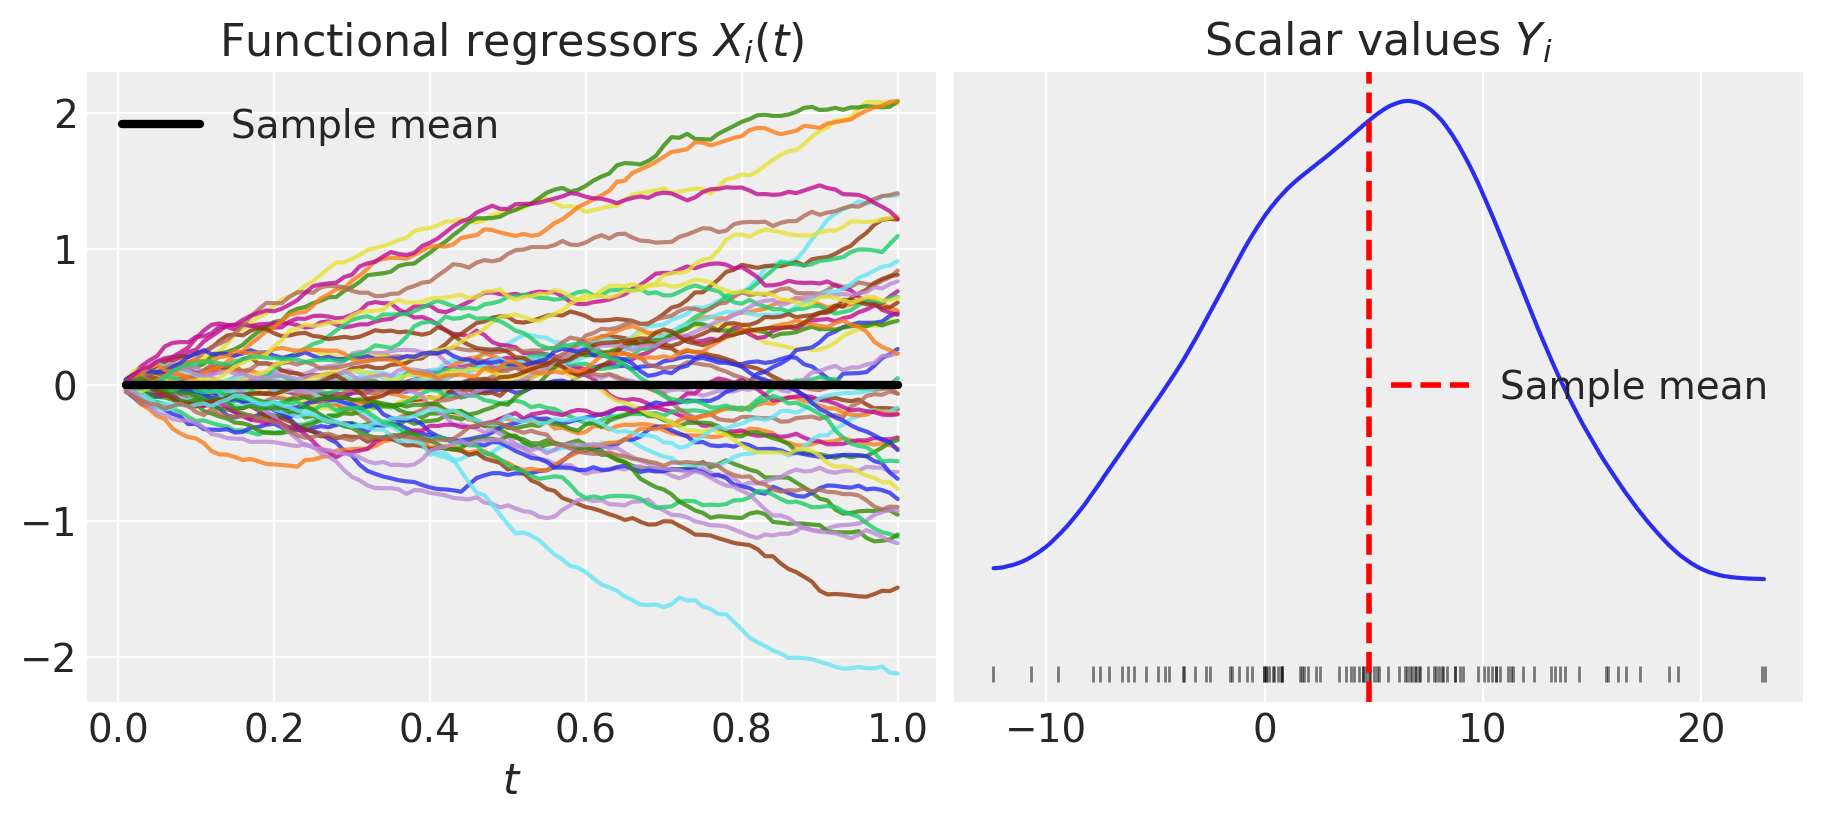

In [5]:
# -- Dataset visualization

plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train if not SYNTHETIC_DATA else n_train//2
)

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [6]:
# -- Model hyperparameters

p_max = 3
g = 5
eta = 0.1

mle_method = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
mle_strategy = 'global'

prior_p = {
    1: 0.1,
    2: 0.35,
    3: 0.55,
}

beta_range = (-500, 500)

INCLUDE_P = False
TRANSFORM_TAU = False
TRANSFORM_SIGMA = True
FIT_SK = False
COMPUTE_MLE = False

In [7]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
theta_names_aux = ["α0 and log σ"]
if INCLUDE_P:
    theta_names = ["p"] + theta_names

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]
if INCLUDE_P:
    theta_labels_grouped = [r"$p$"] + theta_labels_grouped

# Individual labels
theta_labels = [] if not INCLUDE_P else [theta_labels_grouped[0]]
for i in range(p_max):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_max):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={"vector": dict(
        zip(np.arange(p_max), np.arange(1, p_max + 1)))}
)

In [8]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = bayesian_model.Logit()
else:
    tau_ttr = bayesian_model.Identity()

if TRANSFORM_SIGMA:
    sigma2_ttr = bayesian_model.LogSq()
else:
    sigma2_ttr = bayesian_model.Identity()

# Parameter space
theta_space = bayesian_model.ThetaSpace(
    p_max,
    grid,
    include_p=INCLUDE_P,
    names=theta_names,
    labels=theta_labels,
    labeller=theta_labeller,
    tau_range=tau_range,
    beta_range=beta_range,
    tau_ttr=tau_ttr,
    sigma2_ttr=sigma2_ttr
)

# Statistics for posterior predictive checks
point_estimators_bpv = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)
]

# Folds for CV
folds = KFold(shuffle=True, random_state=SEED)

## Sklearn model comparison

In [9]:
# -- Select family of regressors

alphas = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, X.shape[1]]
n_components = [2, 3, 4, 5, 10]
n_basis_bsplines = [8, 10, 12, 14, 16]
n_basis_fourier = [3, 5, 7, 9, 11]
n_neighbors = [3, 5, 7]

basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]

basis_fpls = []
for p in n_components:
    try:
        basis_fpls.append(FPLSBasis(X_fd, Y, n_basis=p))
    except ValueError:
        print(f"Can't create FPLSBasis with n_basis={p}")
        continue

params_regularizer = {"reg__alpha": alphas}
params_svm = {"reg__C": alphas,
              "reg__gamma": ['auto', 'scale']}
params_select = {"selector__p": n_selected}
params_pls = {"reg__n_components": n_components}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}
params_basis_fpca = {"basis__n_basis": n_components}
params_basis_fpls = {"basis__basis": basis_fpls}
params_knn = {"reg__n_neighbors": n_neighbors,
              "reg__weights": ['uniform', 'distance']}
params_mrmr = {"var_sel__method": ["MID", "MIQ"],
               "var_sel__n_features_to_select": n_components}

regressors = utils.linear_regression_comparison_suite(
    params_regularizer,
    params_select,
    params_dim_red,
    params_svm,
    params_basis,
    params_pls,
    params_knn,
    random_state=SEED
)

In [10]:
# -- Fit models and show metrics

if FIT_SK:
    df_metrics_sk, reg_cv = utils.cv_sk(
        regressors, 
        X_fd, 
        Y,
        X_test_fd, 
        Y_test, 
        folds,
        n_jobs=N_CORES,
        verbose=True
    )
    display(df_metrics_sk.style.hide_index())

## Maximum Likelihood Estimator

In [11]:
# -- MLE computation

if COMPUTE_MLE:
    print(f"-- Computing MLE with {N_CORES} independent runs --")

    theta_space_fixed = theta_space.copy_p_fixed()

    mle_theta, bic = mle.compute_mle(
        X,
        Y,
        theta_space_fixed,
        kind='linear',
        method=mle_method,
        strategy=mle_strategy,
        n_jobs=N_CORES,
        rng=rng
    )

    Y_pred_mle = bayesian_model.generate_response_linear(
        X_test, mle_theta, theta_space_fixed, noise=False
    )

    df_metrics_mle = utils.linear_regression_metrics(
        Y_test,
        Y_pred_mle,
        theta_space.p_max,
        "mle"
    )
    print(f"\nBIC [p={p_max}]: {bic:.3f}")
    display(pd.DataFrame(zip(theta_space_fixed.labels, mle_theta),
                         columns=["", "MLE"]).style.hide_index())
    print("Regression metrics:")
    display(df_metrics_mle.style.hide_index())

## The Ensemble Sampler and the *emcee* library

In [12]:
from mcmc_sampler import BayesianLinearRegressionEmcee
import emcee

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [18]:
# -- Sampler iterations

n_walkers = 20
n_iter_warmup = 100
n_iter = 100

compute_pp = False
compute_ll = False
frac_random = 0.3

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

#TODO: b0=mle, initial_state=mle, n_iter, n_iter_warmup, compute_pp

In [19]:
# -- Run sampler

print("-- Running affine-invariant ensemble sampler "
      f"with {N_CORES} cores --")

reg_emcee = BayesianLinearRegressionEmcee(
    theta_space,
    n_walkers,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    n_iter=n_iter,
    n_iter_warmup=n_iter_warmup,
    initial_state='mle',
    frac_random=frac_random,
    moves=moves,
    compute_pp=compute_pp,
    compute_ll=compute_ll,
    thin=thin,
    thin_pp=thin_pp,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    progress_notebook=True,
    random_state=SEED,  # change to 'rng' for different outputs each time
)

if FAST_RUN:
    df_metrics_emcee = utils.run_emcee(
        reg_emcee,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        random_state=SEED,
    )
    if COMPUTE_MLE:
        df_metrics_emcee = df_metrics_emcee.append(df_metrics_mle)
    if FIT_SK:
        df_metrics_emcee = df_metrics_emcee.append(df_metrics_sk)

    df_metrics_emcee.sort_values(
        df_metrics_emcee.columns[-2],
        inplace=True
    )
    display(df_metrics_emcee.style.hide_index())
else:
    reg_emcee.fit(X, Y)
    print(f"Mean acceptance: {100*reg_emcee.mean_acceptance():.3f}%")

idata_emcee = reg_emcee.idata_

-- Running affine-invariant ensemble sampler with 4 cores --
[BFLinReg] Computing MLE...


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:invalid value encountered in subtract


[BFLinReg] MCMC warmup iterations...


[BFLinReg] MCMC:   0%|          | 0/100 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [10.928  9.87  10.923  9.743  9.605 10.921 11.281 12.395]


[BFLinReg] Discarding the first 10 samples...
Mean acceptance: 29.400%


mean     sd  hdi_3%  hdi_97%     min     max  median    mode
β[1]       -0.533  0.844  -1.894    0.172  -2.103   6.070  -0.623  -0.642
β[2]       -2.873  3.839  -5.012    5.568  -5.012  13.454  -3.838  -3.985
β[3]        8.989  5.633  -6.074   11.526 -15.194  11.526  10.452  10.613
τ[1]        0.523  0.124   0.405    0.711   0.002   0.877   0.540   0.538
τ[2]        0.118  0.163   0.001    0.557   0.001   0.995   0.079   0.090
τ[3]        0.758  0.149   0.323    0.814   0.139   0.814   0.799   0.803
$\alpha_0$  4.991  0.282   4.710    5.841   4.522   6.221   4.929   4.912
$\sigma^2$  2.767  6.757   0.538   20.348   0.538  34.250   0.969   0.900


Computing metrics...

Generating posterior predictive samples...


### TEST 1: vectorize compute_pp

In [55]:
# -- Functions

def generate_response_linear(X, theta, theta_space, noise=True, rng=None):
    """Generate a linear response Y given X and θ"""
    theta = np.asarray(theta)
    p, beta, tau, alpha0, sigma2 = theta_space.get_params(theta)

    idx = np.abs(theta_space.grid - tau[:, np.newaxis]).argmin(1)
    y = alpha0 + X[:, idx]@beta

    if noise:
        n = X.shape[0]
        if rng is None:
            rng = np.random.default_rng()

        y += np.sqrt(sigma2)*rng.standard_normal(size=n)

    return y

def generate_response_linear2(X, theta, theta_space, noise=True, rng=None):
    """Generate a linear response Y given X and θ"""
    theta = np.asarray(theta)
    ts = theta_space

    if theta.ndim == 1:
        theta_3d = theta[None, None, :]
    elif theta.ndim == 2:
        theta_3d = theta[None, ...]
    else:
        theta_3d = theta

    if ts.include_p:
        # Replace NaN with 0.0 to "turn off" the corresponding coefficients
        theta_3d = np.nan_to_num(theta_3d, nan=0.0, copy=True)

    beta = theta_3d[..., ts.beta_idx, None]
    tau = theta_3d[..., ts.tau_idx, None]
    alpha0 = theta_3d[..., ts.alpha0_idx, None]

    idx = np.abs(ts.grid - tau).argmin(-1)
    X_idx = np.moveaxis(X[:, idx], 0, -2)
    y = alpha0 + (X_idx@beta).squeeze()

    if noise:
        if rng is None:
            rng = np.random.default_rng()

        sigma2 = theta_3d[..., ts.sigma2_idx, None]
        y += np.sqrt(sigma2)*rng.standard_normal(size=y.shape)

    return y.squeeze()

def generate_response_logistic2(
    X,
    theta,
    theta_space,
    noise=True,
    return_prob=False,
    rng=None
):
    """Generate a logistic response Y given X and θ.

       Returns the response vector and (possibly) the probabilities associated.
    """
    from scipy.special import expit
    y_lin = generate_response_linear2(X, theta, theta_space, noise=False)

    if noise:
        y = rng.binomial(1, expit(y_lin))
    else:
        # sigmoid(x) >= 0.5 iff x >= 0
        y = y_lin.copy().astype(int)
        y[..., y >= 0] = 1
        y[..., y < 0] = 0

    if return_prob:
        return expit(y_lin), y
    else:
        return y

In [56]:
noise=True
thetas=idata_emcee.posterior.to_stacked_array("", sample_dims=("chain", "draw")).values
thetas_orig=thetas.copy()
thetas.shape # (chain, draw n_dim)

(20, 180, 9)

In [57]:
rng=np.random.default_rng(104)
y_star=np.array([[generate_response_linear(X, theta, theta_space, noise=noise, rng=rng) 
                  for theta in draw] for draw in thetas])
print(y_star.shape)  # (chain, draw, len(Y))

(20, 180, 100)


In [58]:
rng=np.random.default_rng(104)
y_star2 = generate_response_linear2(X, thetas, theta_space, noise=noise, rng=rng)
print(y_star2.shape)

(20, 180, 100)


In [59]:
np.allclose(y_star, y_star2)

True

In [60]:
(np.nan_to_num(thetas) == np.nan_to_num(thetas_orig)).all()

True

In [25]:
%%timeit 
np.array(
    [[generate_response_linear(X, theta, theta_space, noise=noise, rng=rng) 
      for theta in draw] for draw in thetas])

2.27 s ± 97.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit generate_response_linear2(X, thetas, theta_space, noise=noise, rng=rng)

15.4 ms ± 563 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### TEST 1: set_unused_nan in trace

In [64]:
def initial_guess_random_include_p(n_samples, rng):

    beta_init = 10 * \
        rng.standard_normal(size=(n_samples, p))
    tau_init = rng.uniform(size=(n_samples, p))
    alpha0_init = rng.standard_normal(size=(n_samples, 1))
    sigma2_init = 1./rng.standard_gamma(1.0, size=(n_samples, 1))

    init = np.hstack((
        beta_init,
        tau_init,
        alpha0_init,
        sigma2_init
    ))

    prior_p = np.full(p, 1./p)

    p_init = rng.choice(
        np.arange(p) + 1,
        size=n_samples,
        p=prior_p
    )

    init = np.vstack((
        p_init,
        init.T
    )).T

    return init if n_samples > 1 else init[0]
def set_unused_nan(theta):
    t = theta.copy()
    pp = np.rint(t[0]).astype(int)
    t[bid[pp:]] = np.nan
    t[tid[pp:]] = np.nan
    return t
def set_unused_nan_inplace(theta):
    pp = np.rint(theta[0]).astype(int)
    theta[bid[pp:]] = np.nan
    theta[tid[pp:]] = np.nan
def set_unused_nan_choose_inplace(theta, inplace):
    t = theta.copy() if not inplace else theta
    pp = np.rint(t[0]).astype(int)
    t[bid[pp:]] = np.nan
    t[tid[pp:]] = np.nan
    if not inplace:
        return t

seed = 6
p = 5
n_iter = 5000
n_walkers = 100
rng = np.random.default_rng(seed)

bid = np.arange(1, p + 1)
tid = np.arange(p + 1, 2*p + 1)

trace = np.array([initial_guess_random_include_p(n_walkers, rng) 
                  for _ in range(n_iter)])
trace_orig = trace.copy()
print(trace.shape)

(5000, 100, 13)


**Copy**

In [67]:
%%timeit 
np.array([[[set_unused_nan(theta) for theta in chain] for chain in trace]])
assert(np.allclose(trace, trace_orig))

3.2 s ± 92.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
%%timeit 
np.array([[[set_unused_nan_choose_inplace(theta, False) for theta in chain] for chain in trace]])
assert(np.allclose(trace, trace_orig))

3.21 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
%%timeit 
funct=np.vectorize(set_unused_nan, signature="(n)->(n)")
funct(trace)
assert(np.allclose(trace, trace_orig))

4.58 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
%%timeit 
funct=np.vectorize(lambda x: set_unused_nan_choose_inplace(x, False), signature="(n)->(n)")
funct(trace)
assert(np.allclose(trace, trace_orig))

4.57 s ± 80.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit 
np.apply_along_axis(set_unused_nan, -1, trace)
assert(np.allclose(trace, trace_orig))

4.12 s ± 244 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
%%timeit 
np.apply_along_axis(lambda x: set_unused_nan_choose_inplace(x, False), -1, trace)
assert(np.allclose(trace, trace_orig))

4.1 s ± 62.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Inplace**

In [74]:
%%timeit 
np.apply_along_axis(set_unused_nan_inplace, -1, trace)
assert(not np.allclose(trace, trace_orig))

4.49 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
rng = np.random.default_rng(seed)
trace = np.array([initial_guess_random_include_p(n_walkers, rng) 
                  for _ in range(n_iter)])

In [76]:
%%timeit 
np.apply_along_axis(lambda x: set_unused_nan_choose_inplace(x, True), -1, trace)
assert(not np.allclose(trace, trace_orig))

4.66 s ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
rng = np.random.default_rng(seed)
trace = np.array([initial_guess_random_include_p(n_walkers, rng) 
                  for _ in range(n_iter)])

In [78]:
%%timeit 
[[[set_unused_nan_inplace(theta) for theta in chain] for chain in trace]]
assert(not np.allclose(trace, trace_orig))

2.6 s ± 173 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
rng = np.random.default_rng(seed)
trace = np.array([initial_guess_random_include_p(n_walkers, rng) 
                  for _ in range(n_iter)])

In [80]:
%%timeit 
[[[set_unused_nan_choose_inplace(theta, True) for theta in chain] for chain in trace]]
assert(not np.allclose(trace, trace_orig))

2.52 s ± 38.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value. The effective sample size is computed as suggested [here (p.66)](https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/mcmc_slides.pdf). Missing values are replaced with a value of $0$.

In [16]:
# -- Sampler statistics and trace (with burn-in and thinning)

# Get number of samples
n_samples_emcee = reg_emcee.total_samples()

# Get autocorrelation times
autocorr = reg_emcee.autocorrelation_times()

pd.DataFrame(
    zip(theta_labels, autocorr, n_samples_emcee/autocorr),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide_index()

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [8.771]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [8.649]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [9.906]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [8.57]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [8.824]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;


In [17]:
# -- Trace summary

reg_emcee.summary()

mean      sd  hdi_3%  hdi_97%     min     max  median    mode
p            2.739   0.541   2.000    3.000   1.000   3.000   3.000   3.000
β[1]        -1.179   1.643  -2.759    3.371  -5.116   3.371  -1.711  -1.825
β[2]        -2.436   4.378  -6.086    6.928  -6.086  11.074  -4.221  -4.092
β[3]        11.437   0.567  10.403   12.406  10.062  13.348  11.452  11.798
τ[1]         0.620   0.102   0.428    0.871   0.361   0.952   0.606   0.613
τ[2]         0.248   0.230   0.080    0.777   0.037   0.818   0.151   0.108
τ[3]         0.792   0.010   0.775    0.808   0.719   0.820   0.793   0.793
$\alpha_0$   4.898   0.776   4.252    6.833   3.755   7.588   4.613   4.597
$\sigma^2$   8.185  13.840   0.440   37.547   0.387  46.497   1.300   0.883

Combined density and trace plot:


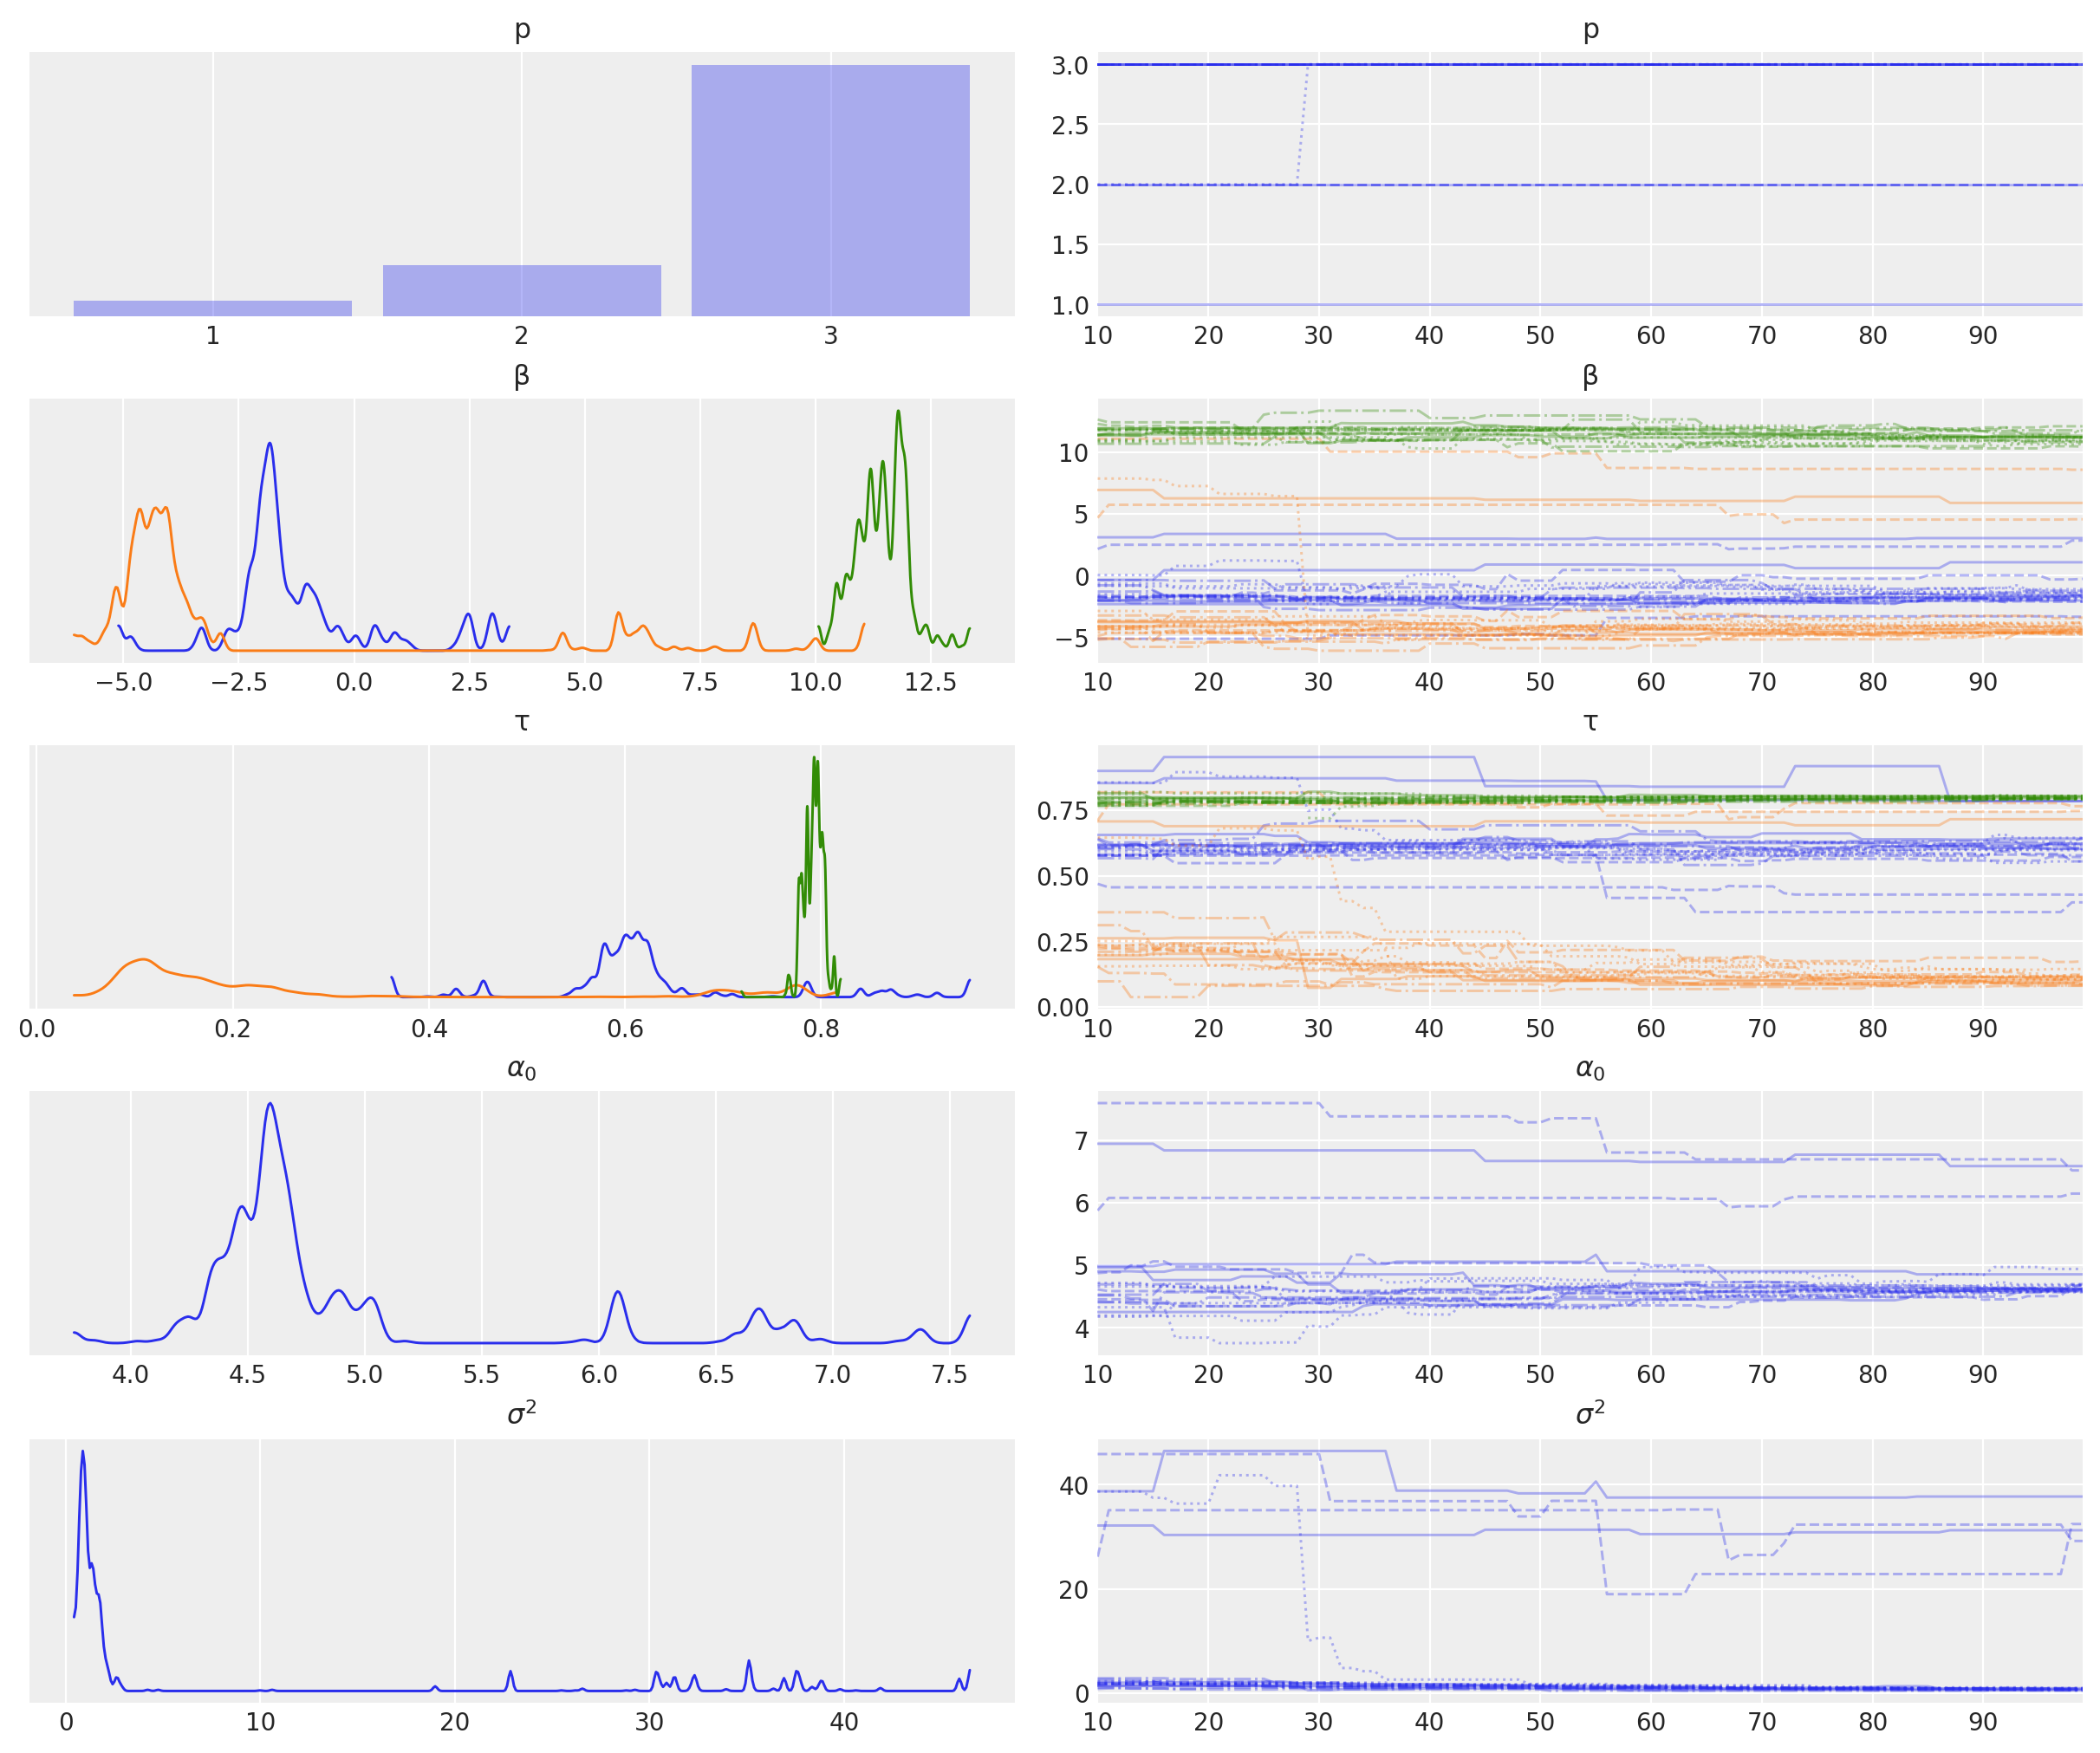

In [18]:
# -- Trace plot

az.plot_trace(
    idata_emcee, 
    labeller=theta_labeller,
    combined=True, 
    var_names=theta_names
)

print("Combined density and trace plot:")

Marginal posterior distributions:


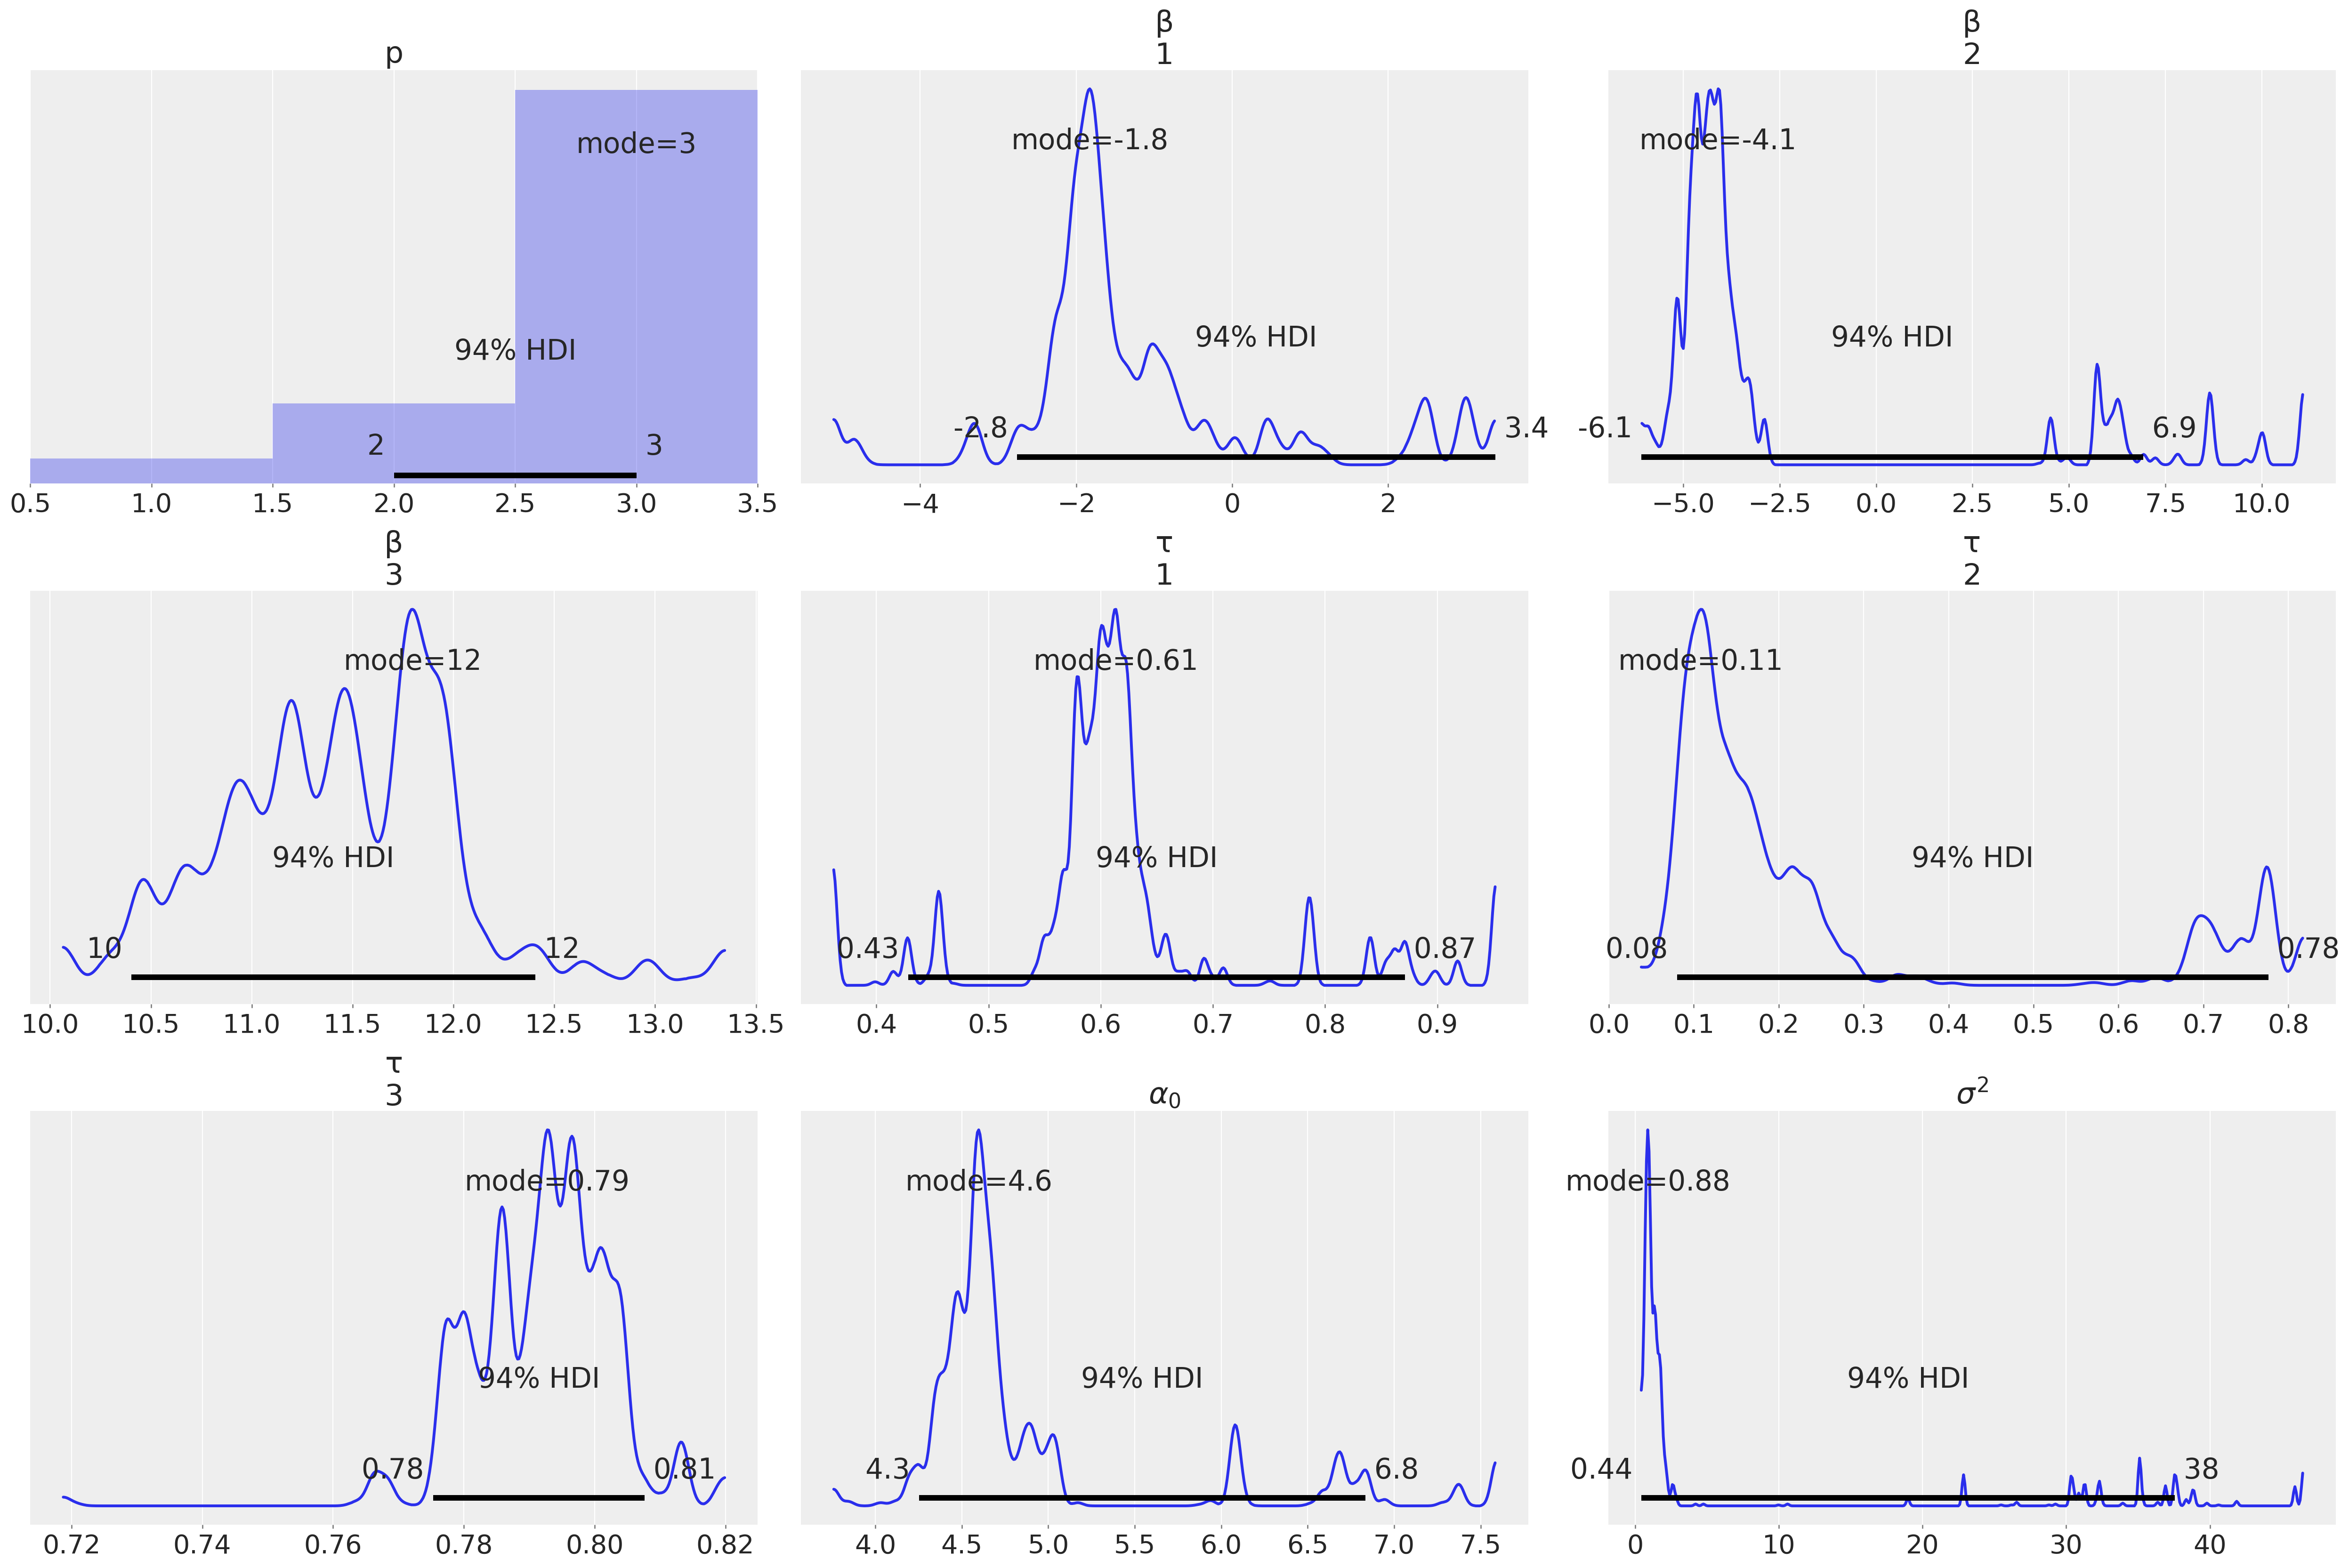

In [19]:
# -- Marginal posterior plot

az.plot_posterior(
    idata_emcee.posterior.dropna("vector", how="all"),
    labeller=theta_labeller,
    point_estimate='mode',
    grid=(NROWS(theta_space.n_dim), NCOLS), 
    textsize=20,
    skipna=INCLUDE_P,
    var_names=theta_names
)

print("Marginal posterior distributions:")

We can perform a couple of visual posterior predictive checks. In particular:
    
- A plot of the distribution of $Y$ and the distribution of $\{Y^*_m\}_m$ (one for every sample $\theta_m$ of the chain), generated using the original traning data $X$.
- A plot of the distribution of $T(Y^*)$, where $T(x)=\bar x$. 

We also show the Bayesian p-value for several statistics, which is defined as $P(T(y^*)\leq T(y)\mid y)$, and is computed by simply measuring the proportion of generated samples $\{T(Y^*_m)\}_m$ that fall below the real value of the statistic. It is expected to be around $0.5$ when the model accurately represents the data.

Generating posterior predictive samples...
bpv [T=min]: 0.499
bpv [T=max]: 0.409
bpv [T=median]: 0.437
bpv [T=mean]: 0.719
bpv [T=std]: 0.646


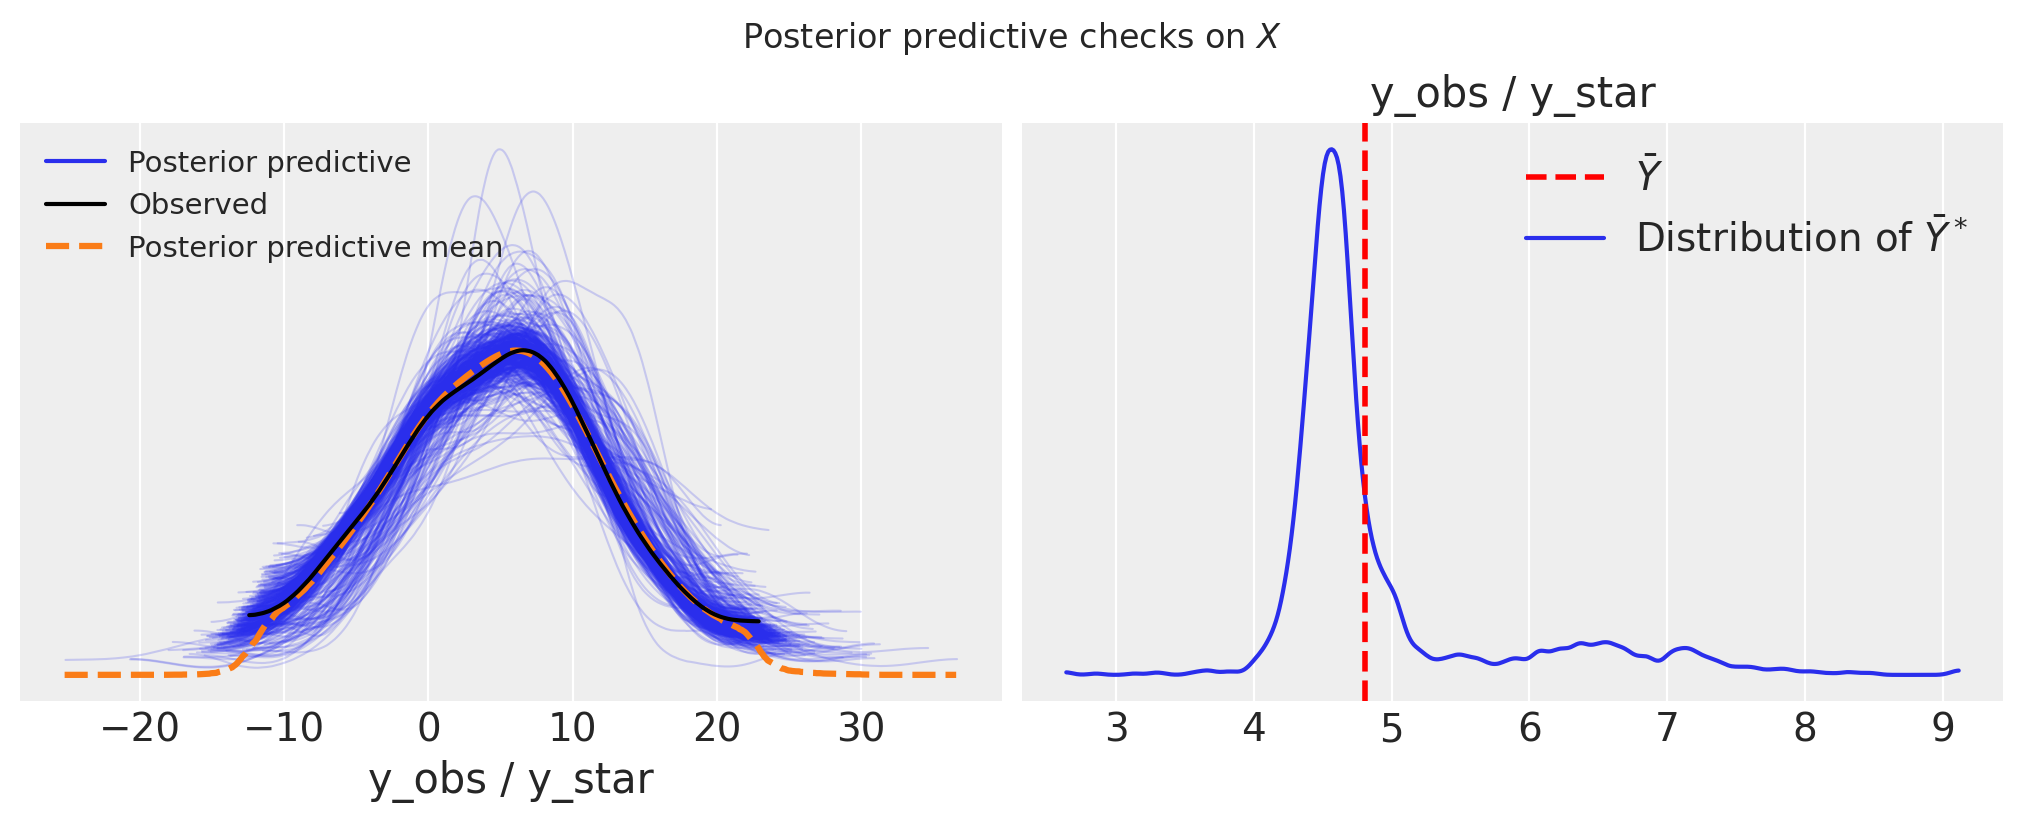

In [20]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp = bayesian_model.generate_pp(
        idata_emcee, X, theta_space, rng=rng, verbose=True)
    utils.pp_to_idata([pp], idata_emcee, ['y_star'], merge=True)
else:
    pp = idata_emcee.posterior_predictive['y_star'].to_numpy()

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X$")

plot_utils.plot_ppc(
    idata_emcee,
    n_samples=500,
    ax=axs[0],
    data_pairs={'y_obs': 'y_star'}
)

az.plot_bpv(idata_emcee,
            kind='t_stat',
            t_stat='mean',
            ax=axs[1],
            plot_mean=False,
            data_pairs={'y_obs': 'y_star'},
            bpv=False
            )
axs[1].axvline(Y.mean(),
               ls="--",
               color="r",
               lw=2,
               label=r"$\bar Y$"
               )
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


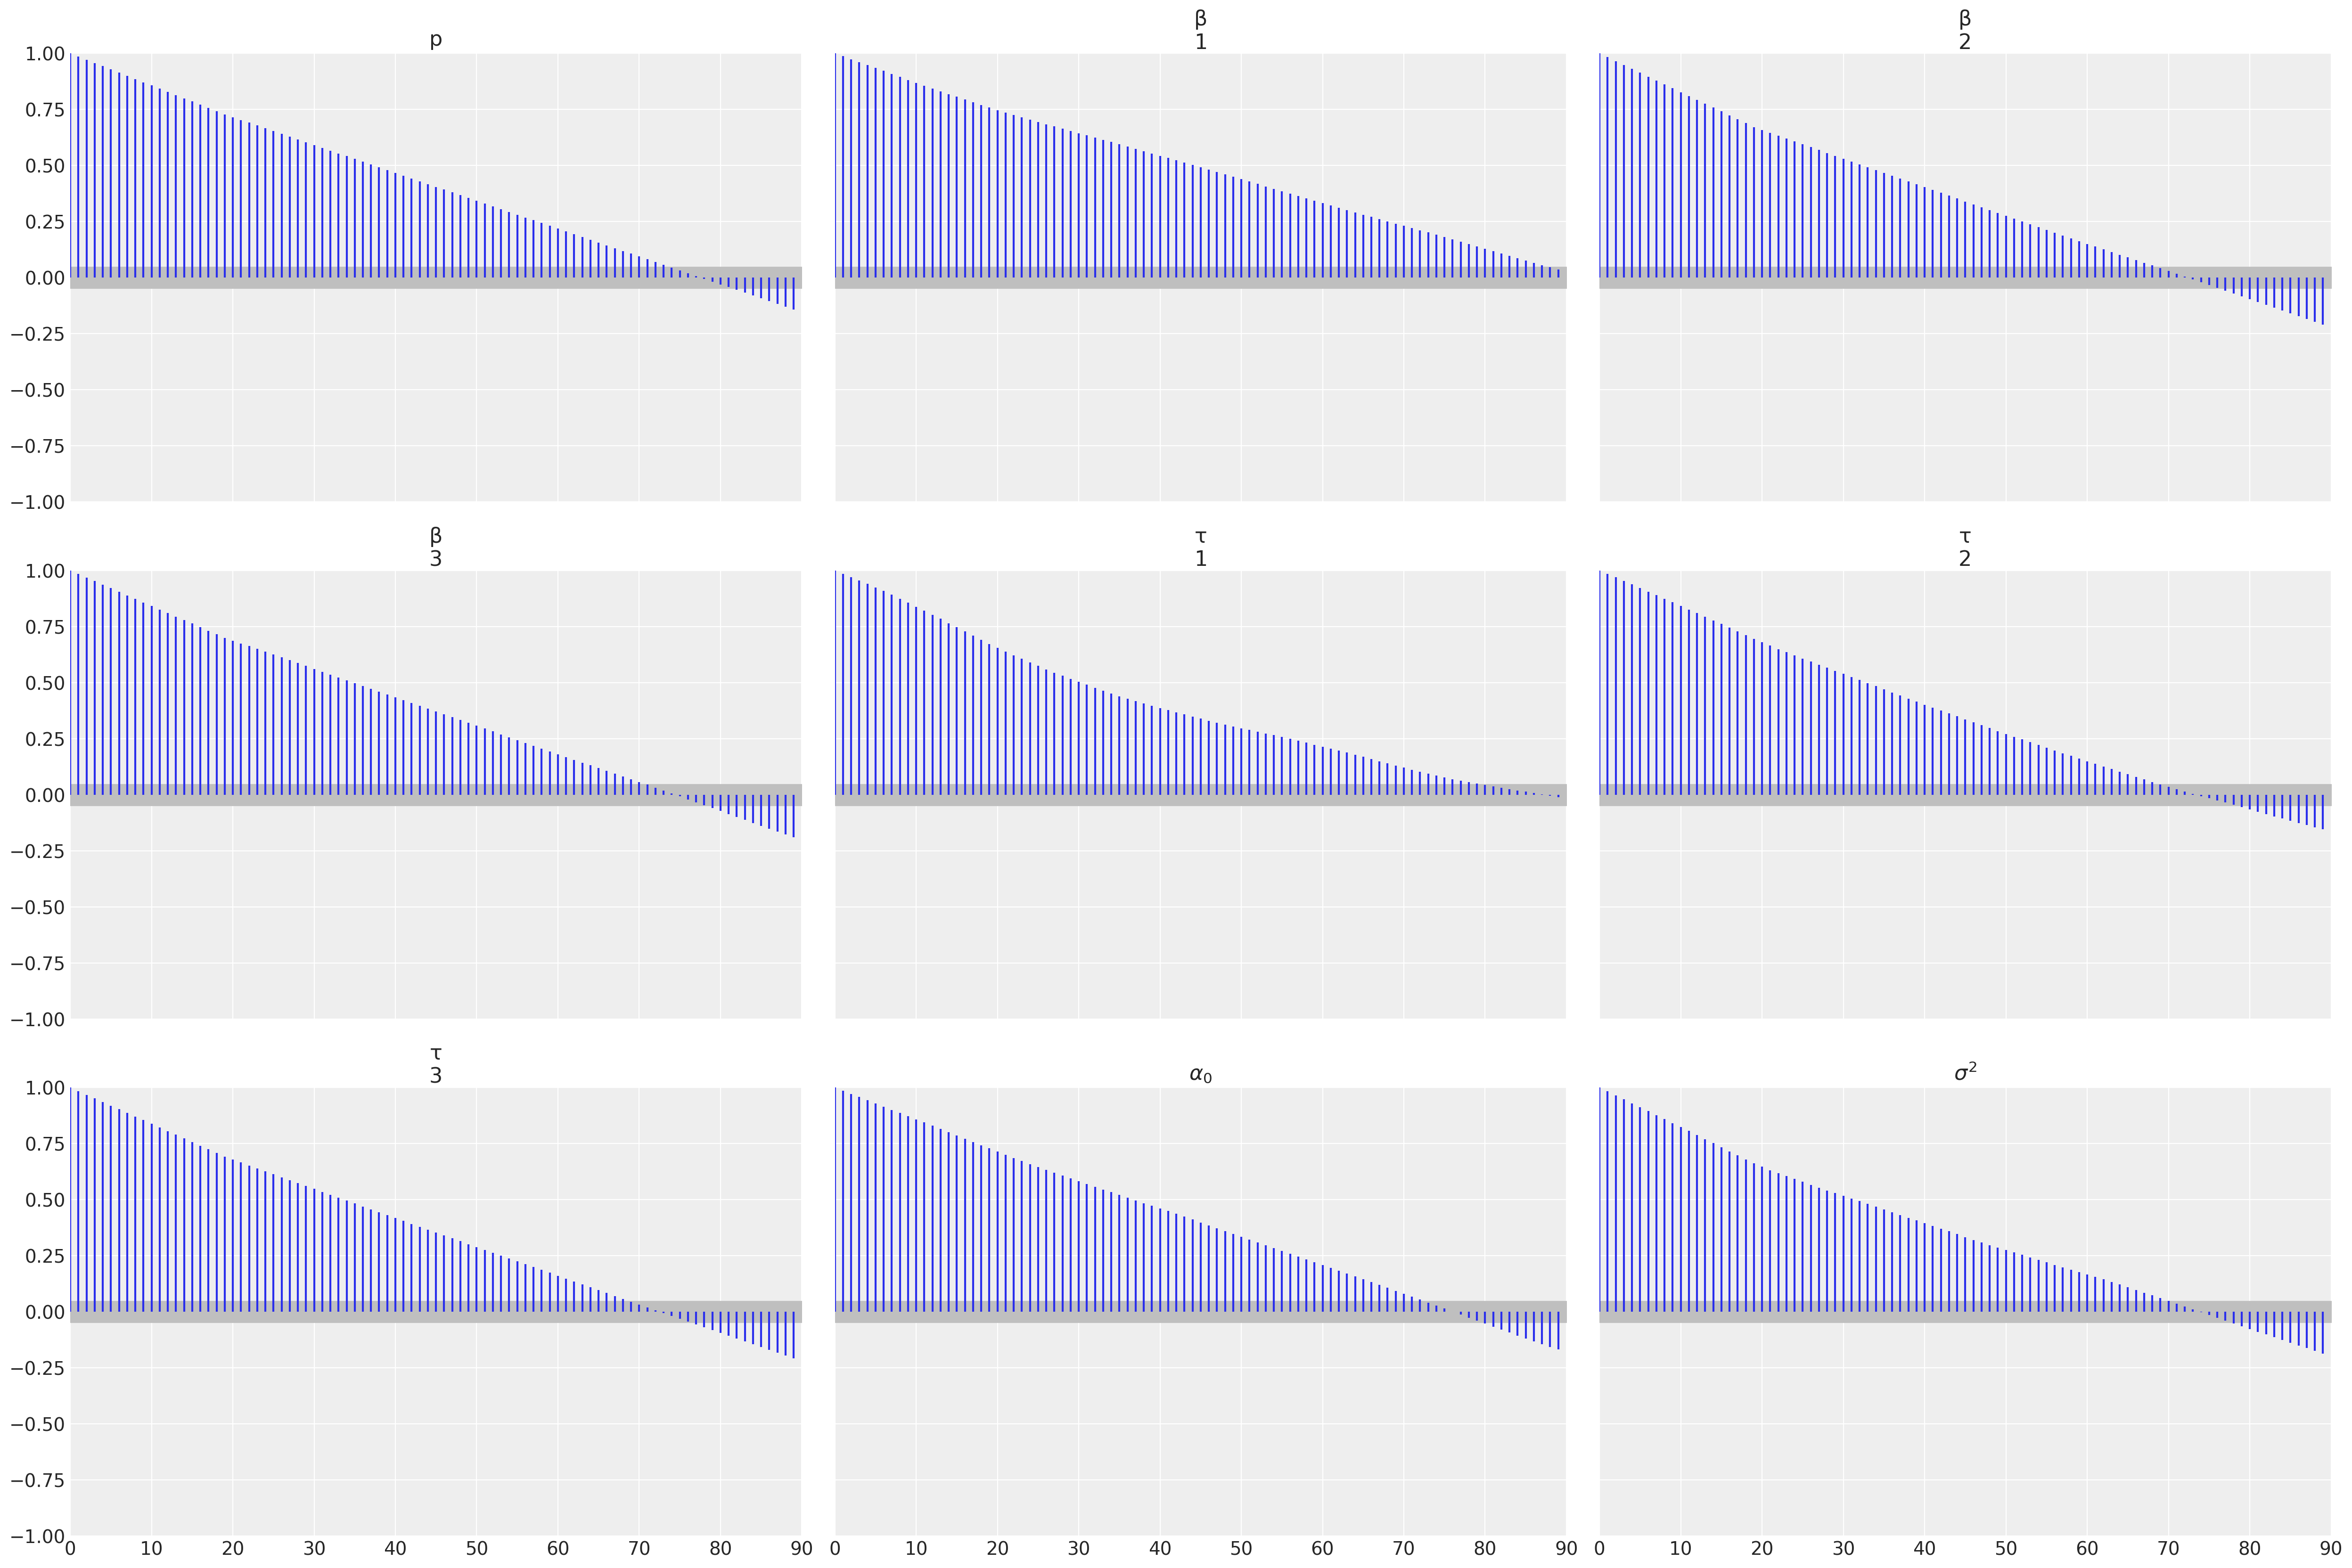

In [21]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_emcee,
    theta_space,
    (NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

### Out-of-sample predictions

Generating posterior predictive samples...
bpv [T=min]: 0.208
bpv [T=max]: 0.542
bpv [T=median]: 0.868
bpv [T=mean]: 0.706
bpv [T=std]: 0.654


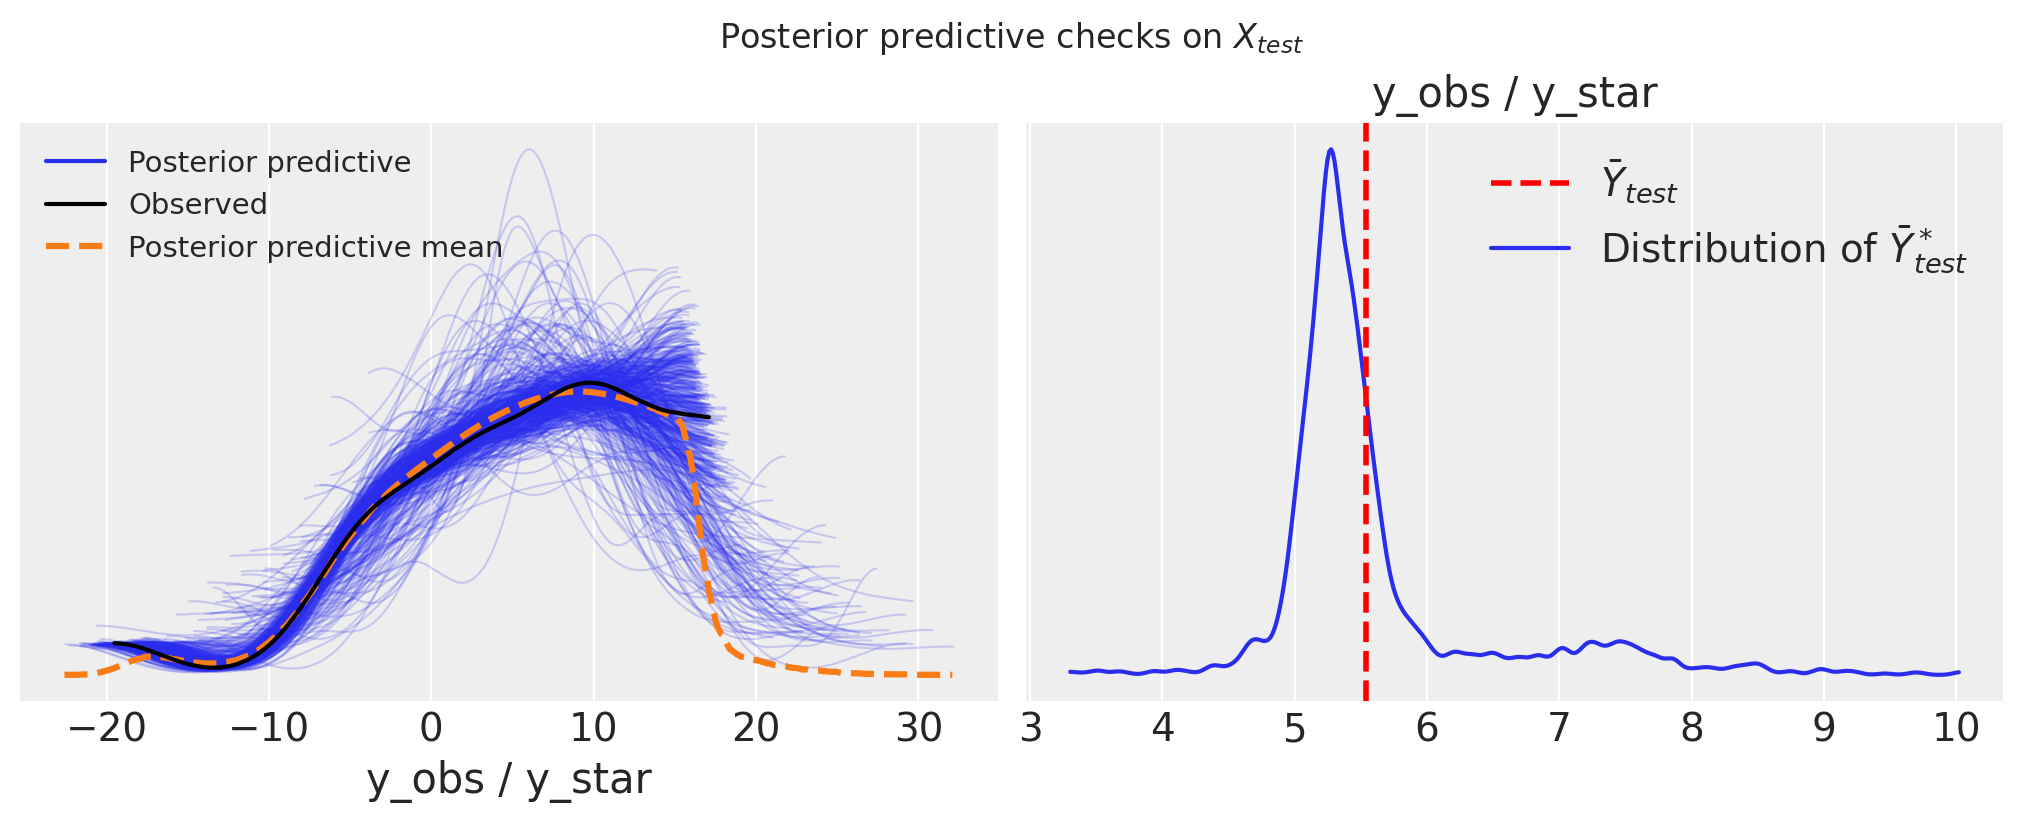

In [22]:
# -- Generate and plot posterior predictive checks from X_test

# Posterior predictive checks
pp_test = bayesian_model.generate_pp(
    idata_emcee,
    X_test,
    theta_space,
    rng=rng,
    verbose=True,
)
idata_pp_test = utils.pp_to_idata(
    [pp_test], idata_emcee, ['y_star'], y_obs=Y_test)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

plot_utils.plot_ppc(
    idata_pp_test,
    n_samples=500,
    data_pairs={'y_obs': 'y_star'},
    ax=axs[0]
)

az.plot_bpv(
    idata_pp_test, 
    kind='t_stat', 
    t_stat='mean', 
    data_pairs={'y_obs': 'y_star'}, 
    plot_mean=False, 
    ax=axs[1], 
    bpv=False
)

axs[1].axvline(
    Y_test.mean(), 
    ls="--",
    color="r", 
    lw=2, 
    label=r"$\bar Y_{test}$"
)

handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*_{test}$")])
_ = axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [23]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_emcee = utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_emcee.n_components("posterior_mean"),
    "emcee_posterior_mean"
)

# Point estimates
for pe in reg_emcee.default_point_estimates:
    Y_pred_pe = reg_emcee.predict(X_test, strategy=pe)
    df_metrics_emcee = utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_emcee.n_components(pe),
        "emcee_" + pe,
        df=df_metrics_emcee,
    )

df_metrics_emcee.style.hide_index()

In [24]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = None

for pe in reg_emcee.default_point_estimates:
    X_red = reg_emcee.transform(X, pe=pe)
    X_test_red = reg_emcee.transform(X_test, pe=pe)

    df_metrics_emcee_var_sel = utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="emcee",
        pe=pe,
        df=df_metrics_emcee_var_sel,
    )

df_metrics_emcee_var_sel.style.hide_index()

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [44]:
# -- Save

with open("emcee-p-fixed.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [45]:
# -- Load

with open("emcee-p-fixed.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [28]:
import pymc3 as pm
import theano.tensor as tt

### Model

In [29]:
# -- Probabilistic model

def make_model(theta_space, g, eta, X, Y, names, names_aux, mle_theta=None):
    n, N = X.shape
    grid = theta_space.grid
    p = theta_space.p

    if mle_theta is not None:
        b0 = mle_theta[:p]
    else:
        b0 = g*rng.standard_normal(size=p)  # <-- Change if needed

    with pm.Model() as model:
        X_pm = pm.Data('X', X)

        alpha0_and_log_sigma = pm.DensityDist(
            names_aux[0], lambda x: 0, shape=(2,))

        alpha0 = pm.Deterministic(names[-2], alpha0_and_log_sigma[0])

        log_sigma = alpha0_and_log_sigma[1]
        sigma = pm.math.exp(log_sigma)
        sigma2 = pm.Deterministic(names[-1], sigma**2)

        tau = pm.Uniform(names[1], 0.0, 1.0, shape=(p,))

        idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
        X_tau = X_pm[:, idx]
        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        G_tau_reg = G_tau + eta * \
            tt.max(tt.nlinalg.eigh(G_tau)[0])*np.identity(p)

        def beta_lprior(x):
            b = x - b0

            return (0.5*pm.math.logdet(G_tau_reg)
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta = pm.DensityDist(names[0], beta_lprior, shape=(p,))

        expected_obs = alpha0 + pm.math.matrix_dot(X_tau, beta)

        y_obs = pm.Normal('y_obs', mu=expected_obs, sigma=sigma, observed=Y)

    return model

### Experiments

In [30]:
# -- Hyperparameters

burn = 0
thin = 1
thin_pp = 5

n_samples_nuts = 1000
tune_nuts = 1000
target_accept = 0.8
n_samples_metropolis = 10000
tune_metropolis = 5000

USE_NUTS = False

In [31]:
# -- Run sampler

model = make_model(theta_space, g, eta, X, Y, theta_names,
                   theta_names_aux[:1], mle_theta_tr)

with model:
    if USE_NUTS:
        idata_pymc = pm.sample(n_samples_nuts, cores=2,
                               tune=tune_nuts,
                               target_accept=target_accept,
                               return_inferencedata=True)
    else:
        step = pm.Metropolis()
        idata_pymc = pm.sample(n_samples_metropolis, cores=2,
                               tune=tune_metropolis, step=step,
                               return_inferencedata=True)

    idata_pymc = idata_pymc.sel(draw=slice(burn, None, thin))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [β]
>Metropolis: [τ]
>Metropolis: [α0 and log σ]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 27 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

In [32]:
utils.summary(idata_pymc, var_names=theta_names, labeller=theta_labeller)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[0]        -3.904  0.548  -4.904   -2.881      0.033    0.023     281.0   
β[1]        10.090  0.099   9.907   10.279      0.003    0.002     877.0   
β[2]        -2.973  0.630  -4.080   -1.767      0.095    0.067      50.0   
τ[0]         0.050  0.038   0.004    0.104      0.022    0.018       4.0   
τ[1]         0.799  0.004   0.790    0.805      0.000    0.000    2275.0   
τ[2]         0.069  0.044   0.003    0.118      0.027    0.021       4.0   
$\alpha_0$   4.802  0.069   4.668    4.926      0.001    0.001    2215.0   
$\sigma^2$   0.478  0.070   0.352    0.606      0.002    0.001    1411.0   

            ess_tail  r_hat    mode  median  
β[0]           534.0   1.01  -3.945  -3.914  
β[1]          2304.0   1.00  10.077  10.085  
β[2]           145.0   1.05  -3.136  -3.027  
τ[0]            23.0   1.53   0.013   0.028  
τ[1]          2545.0   1.00   0.803   0.800  
τ[2]            55.0   1.57   0.008   0.089  
$\alpha_0$    3398.0   1.00   4.778   4.800  
$\sigma^2$    2687.0   1.00   0.457   0.471

Density and trace plot:


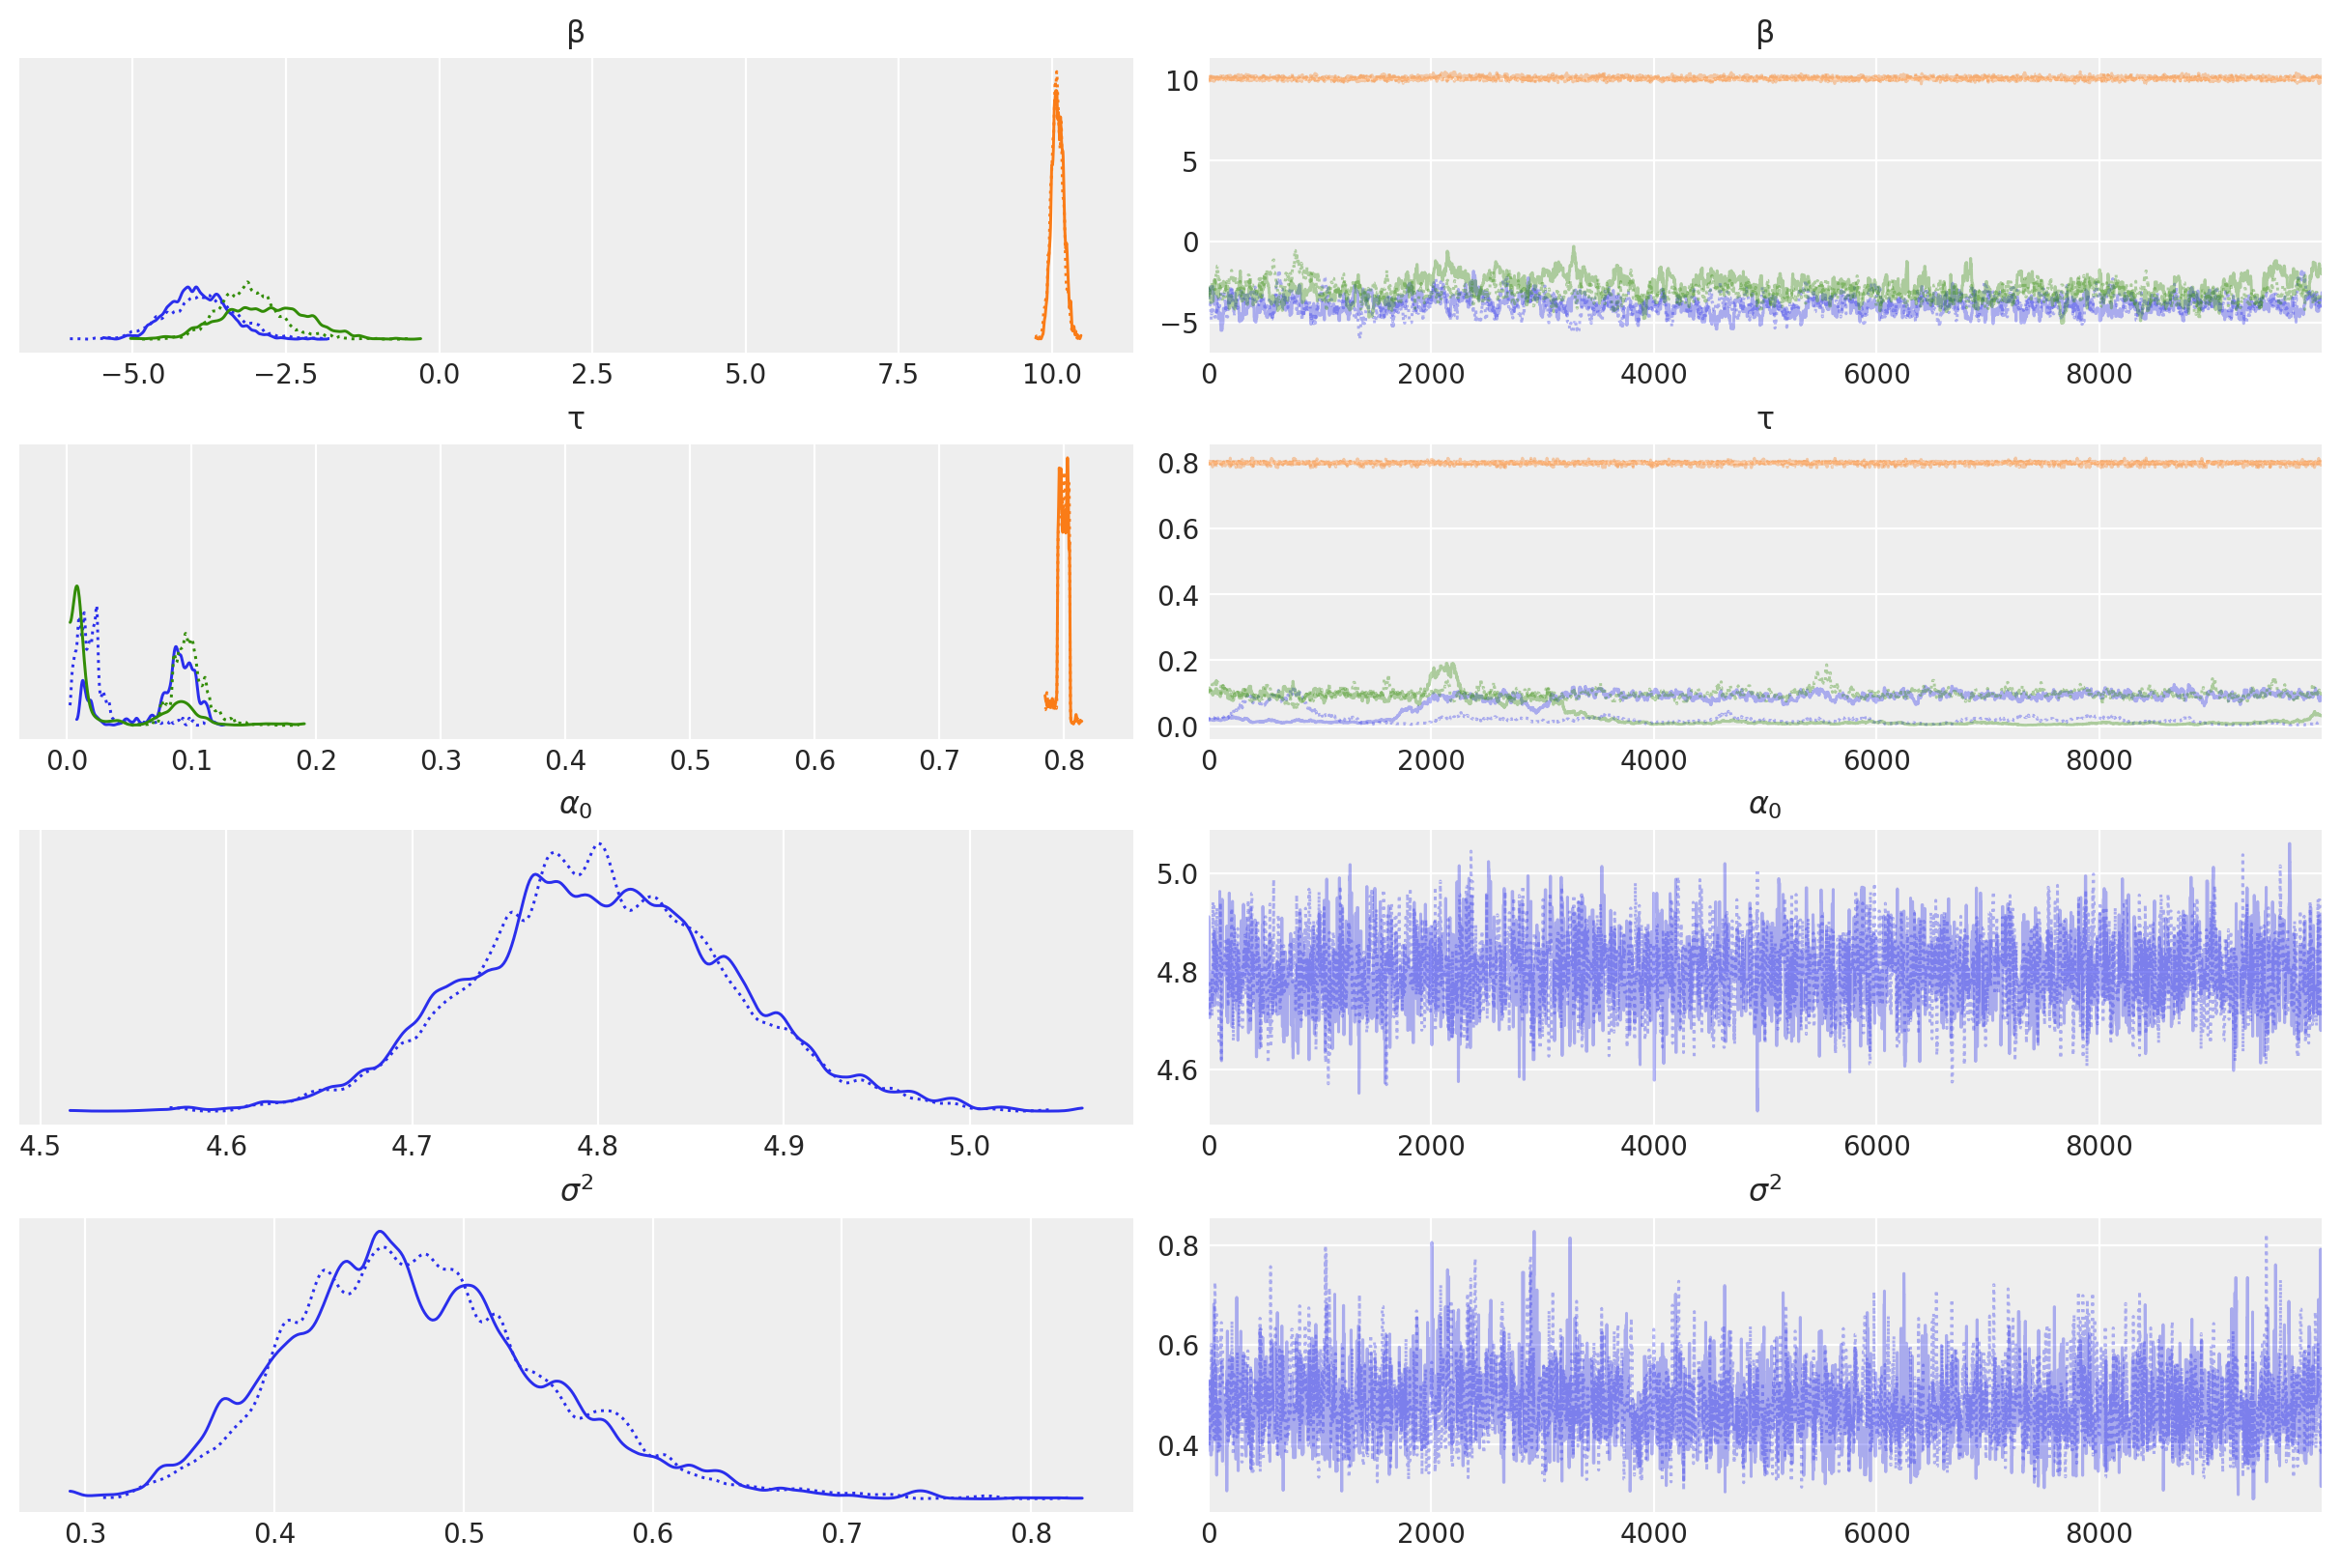

In [33]:
az.plot_trace(idata_pymc, var_names=theta_names, labeller=theta_labeller)
print("Density and trace plot:")

Marginal posterior distributions:


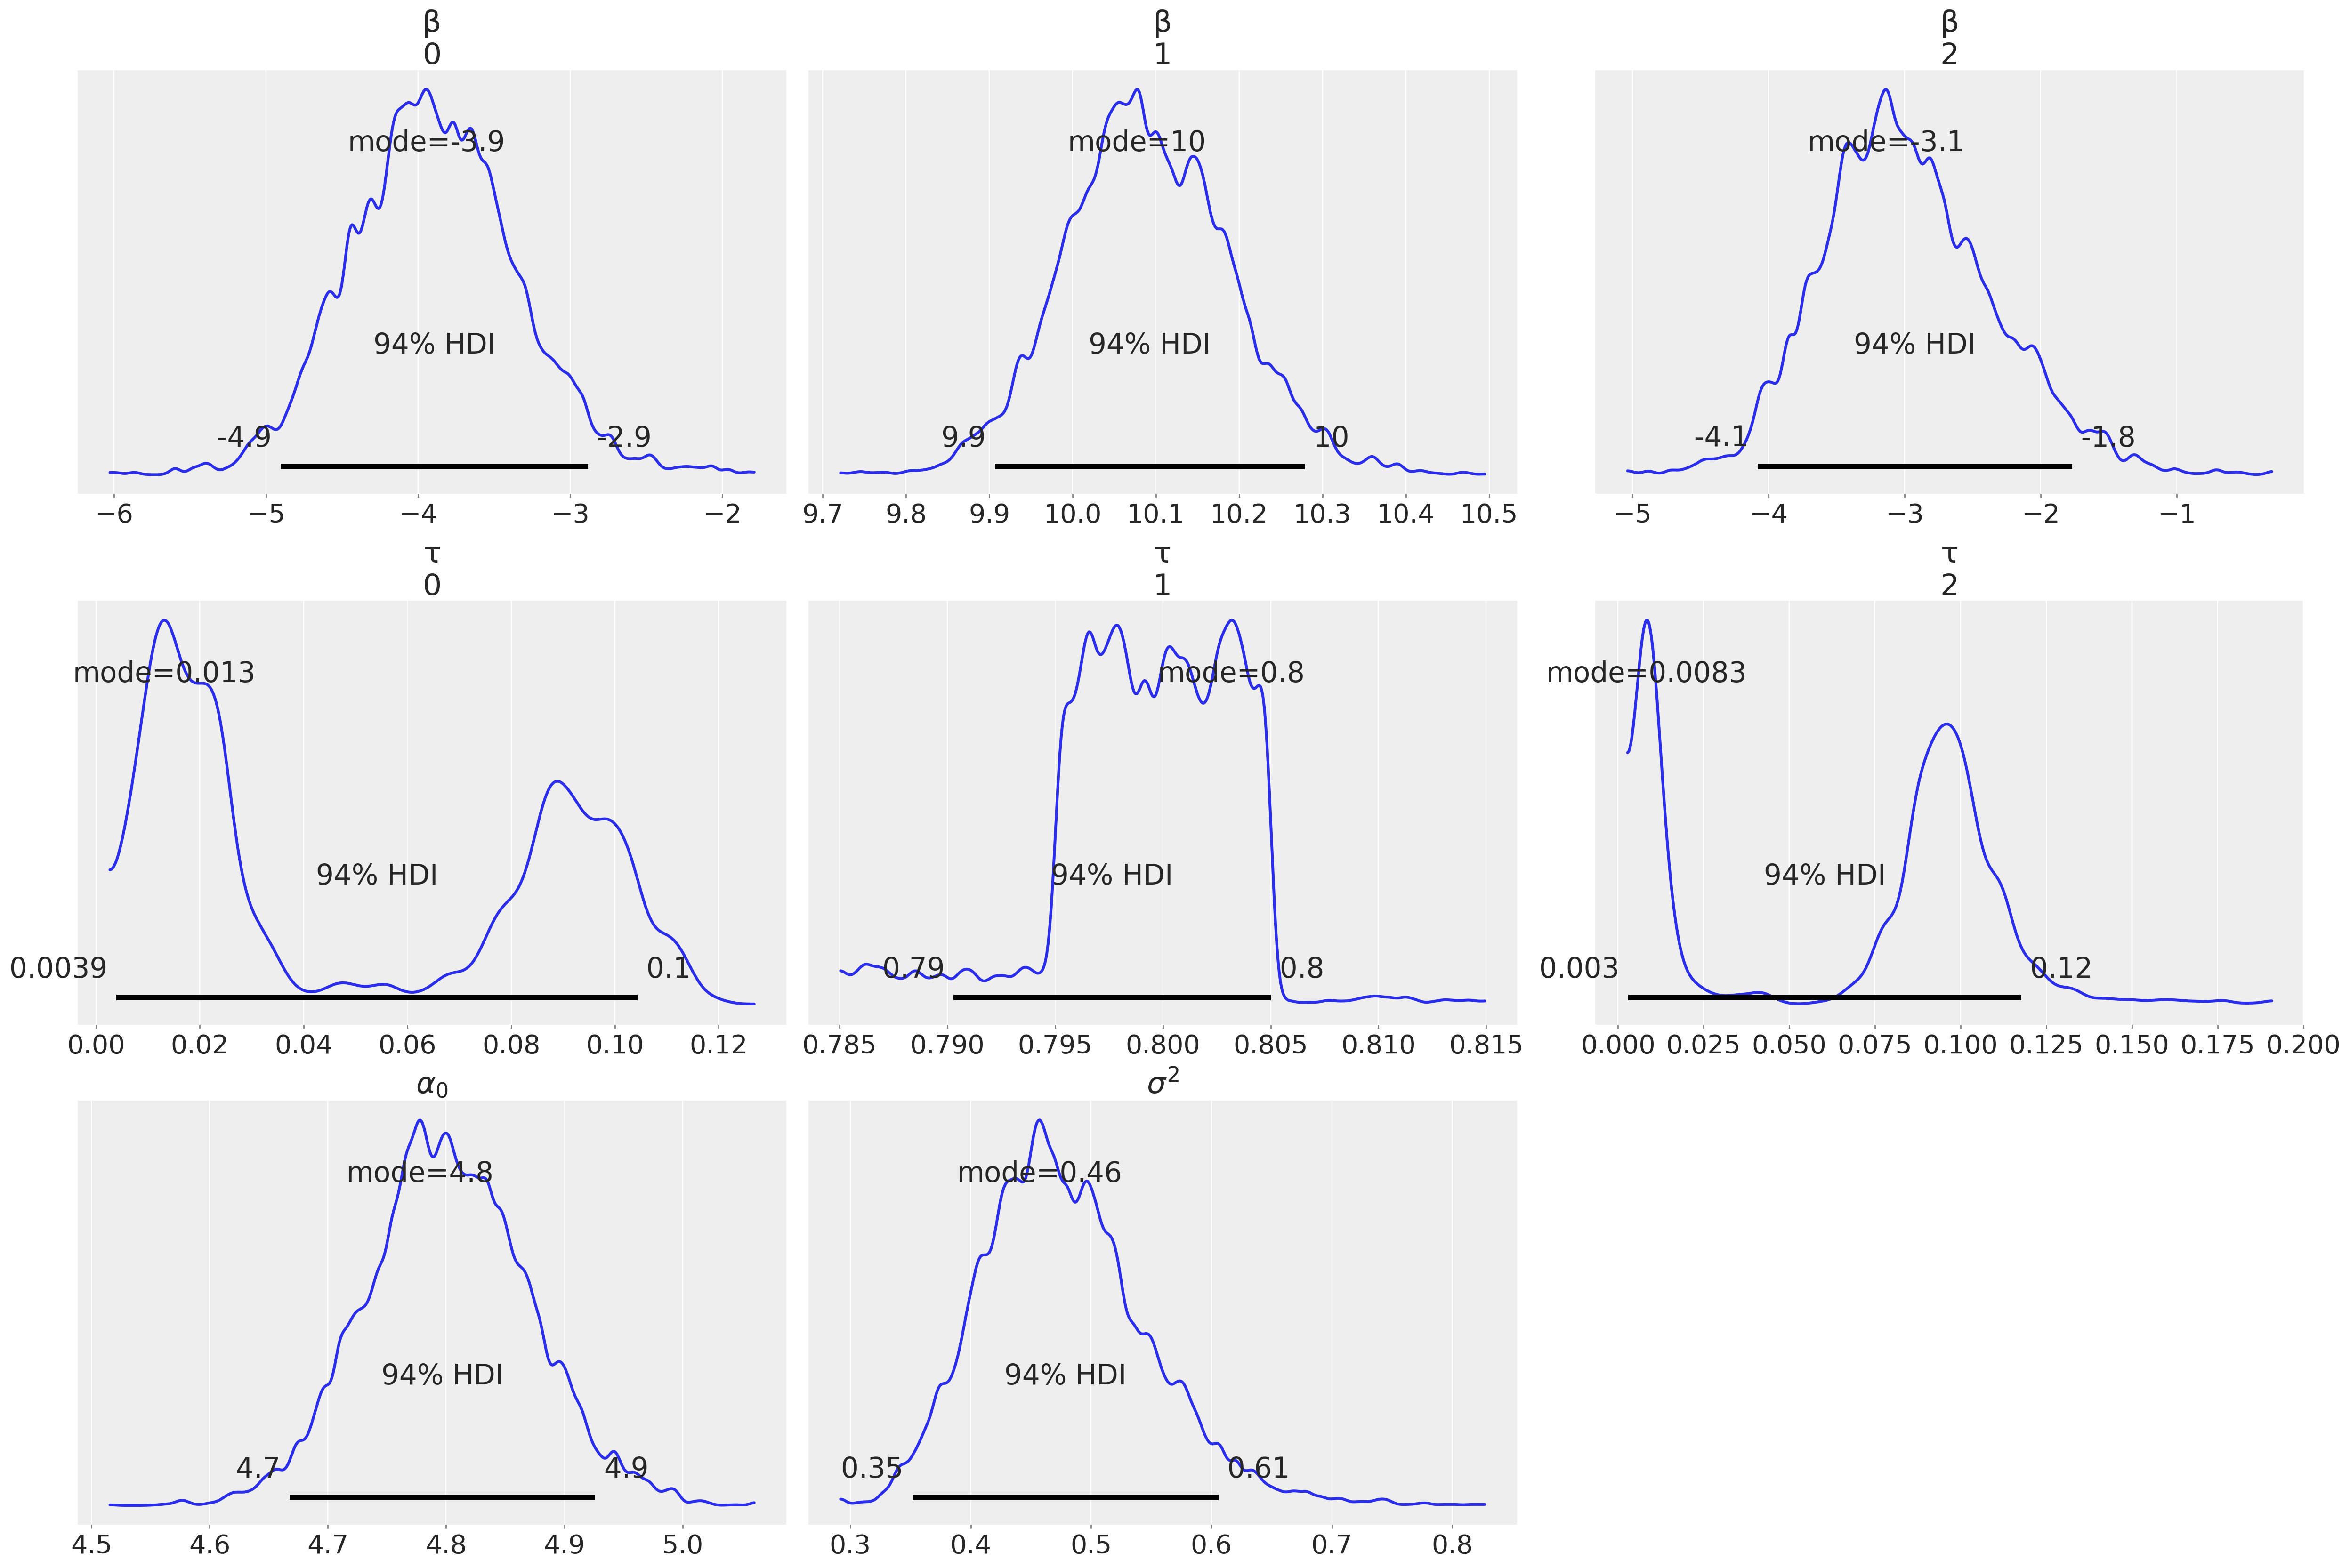

In [34]:
az.plot_posterior(
    idata_pymc, point_estimate='mode',
    var_names=theta_names,
    labeller=theta_labeller,
    textsize=20,
    grid=(NROWS(theta_ndim), NCOLS))
print("Marginal posterior distributions:")

Generating posterior predictive samples...


Posterior predictive samples:   0%|          | 0/2 [00:00<?, ?it/s]

bpv [T=min]: 0.579
bpv [T=max]: 0.089
bpv [T=median]: 0.262
bpv [T=mean]: 0.509
bpv [T=std]: 0.506


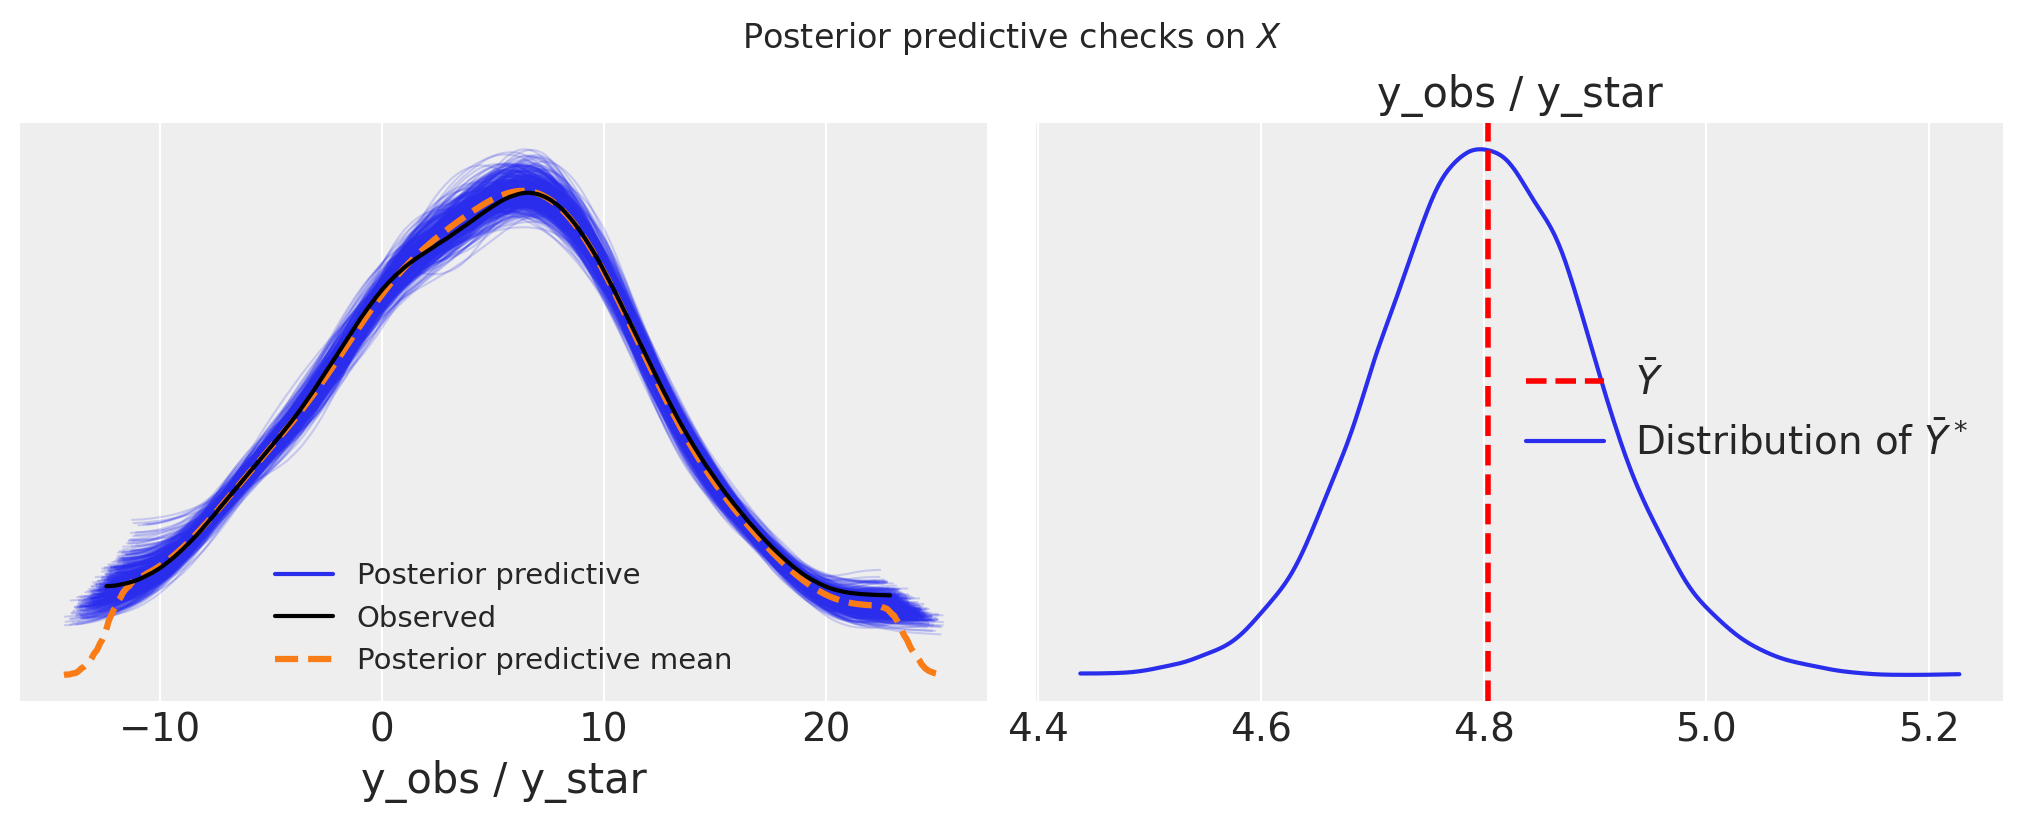

In [35]:
# -- Generate and plot posterior predictive samples from X

with model:
    print("Generating posterior predictive samples...")
    pp = utils.generate_pp(idata_pymc, X, theta_names, rng=rng)
    utils.pp_to_idata([pp], idata_pymc, ['y_star'], merge=True)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X$")

utils.plot_ppc(idata_pymc, n_samples=500,
               ax=axs[0], data_pairs={"y_obs": "y_star"})

az.plot_bpv(idata_pymc, kind='t_stat', t_stat='mean',
            plot_mean=False, ax=axs[1],
            bpv=False, data_pairs={"y_obs": "y_star"})
axs[1].axvline(Y.mean(), ls="--",
               color="r", lw=2, label=r"$\bar Y$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
_ = axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = utils.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


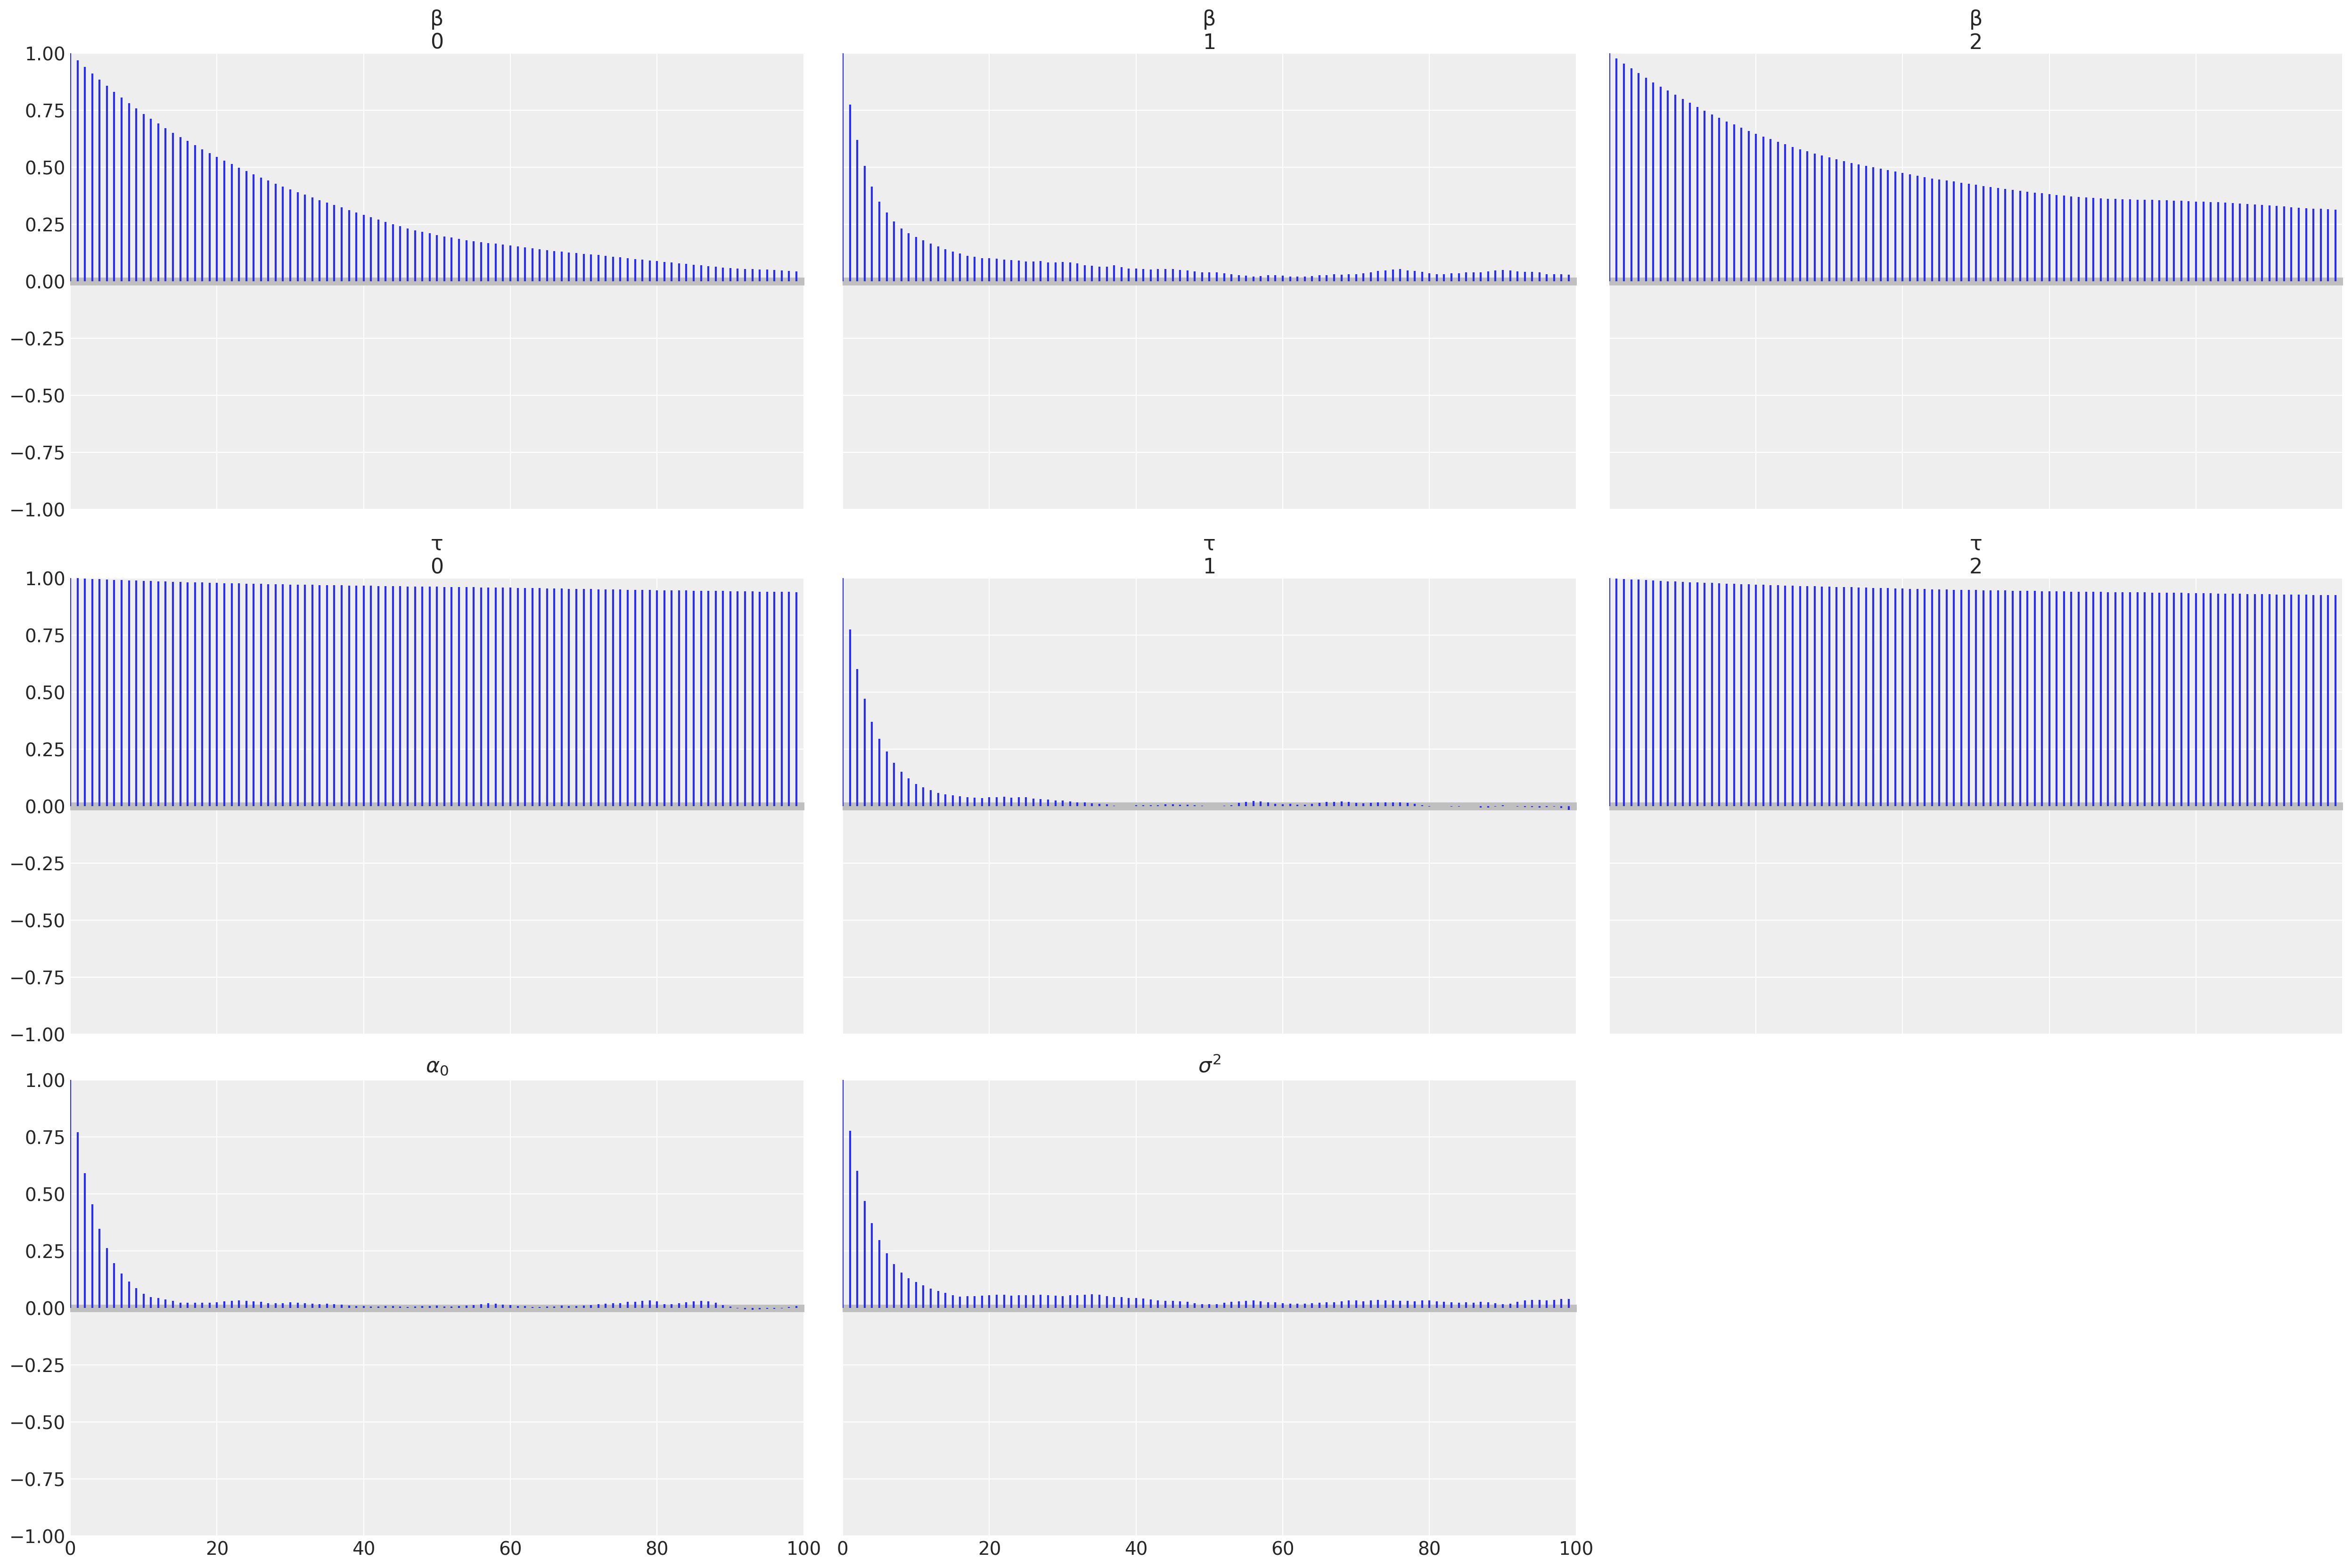

In [36]:
az.plot_autocorr(idata_pymc, var_names=theta_names,
                 combined=True, grid=(NROWS(theta_ndim), NCOLS),
                 labeller=theta_labeller)
print("Combined autocorrelation times:")

Graphical model:


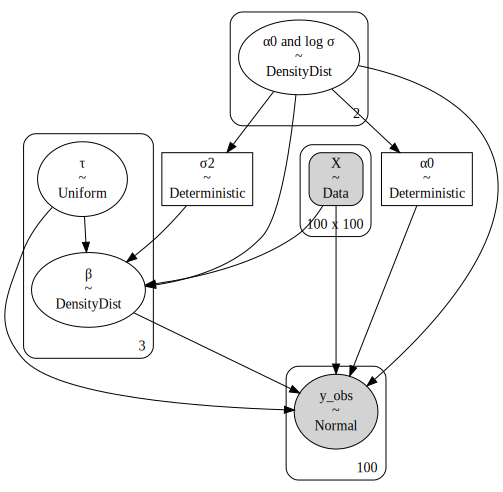

In [40]:
print("Graphical model:")
pm.model_graph.model_to_graphviz(model)

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive on hold-out data...


Posterior predictive samples:   0%|          | 0/2 [00:00<?, ?it/s]

bpv [T=min]: 0.250
bpv [T=max]: 0.611
bpv [T=median]: 0.973
bpv [T=mean]: 0.480
bpv [T=std]: 0.494


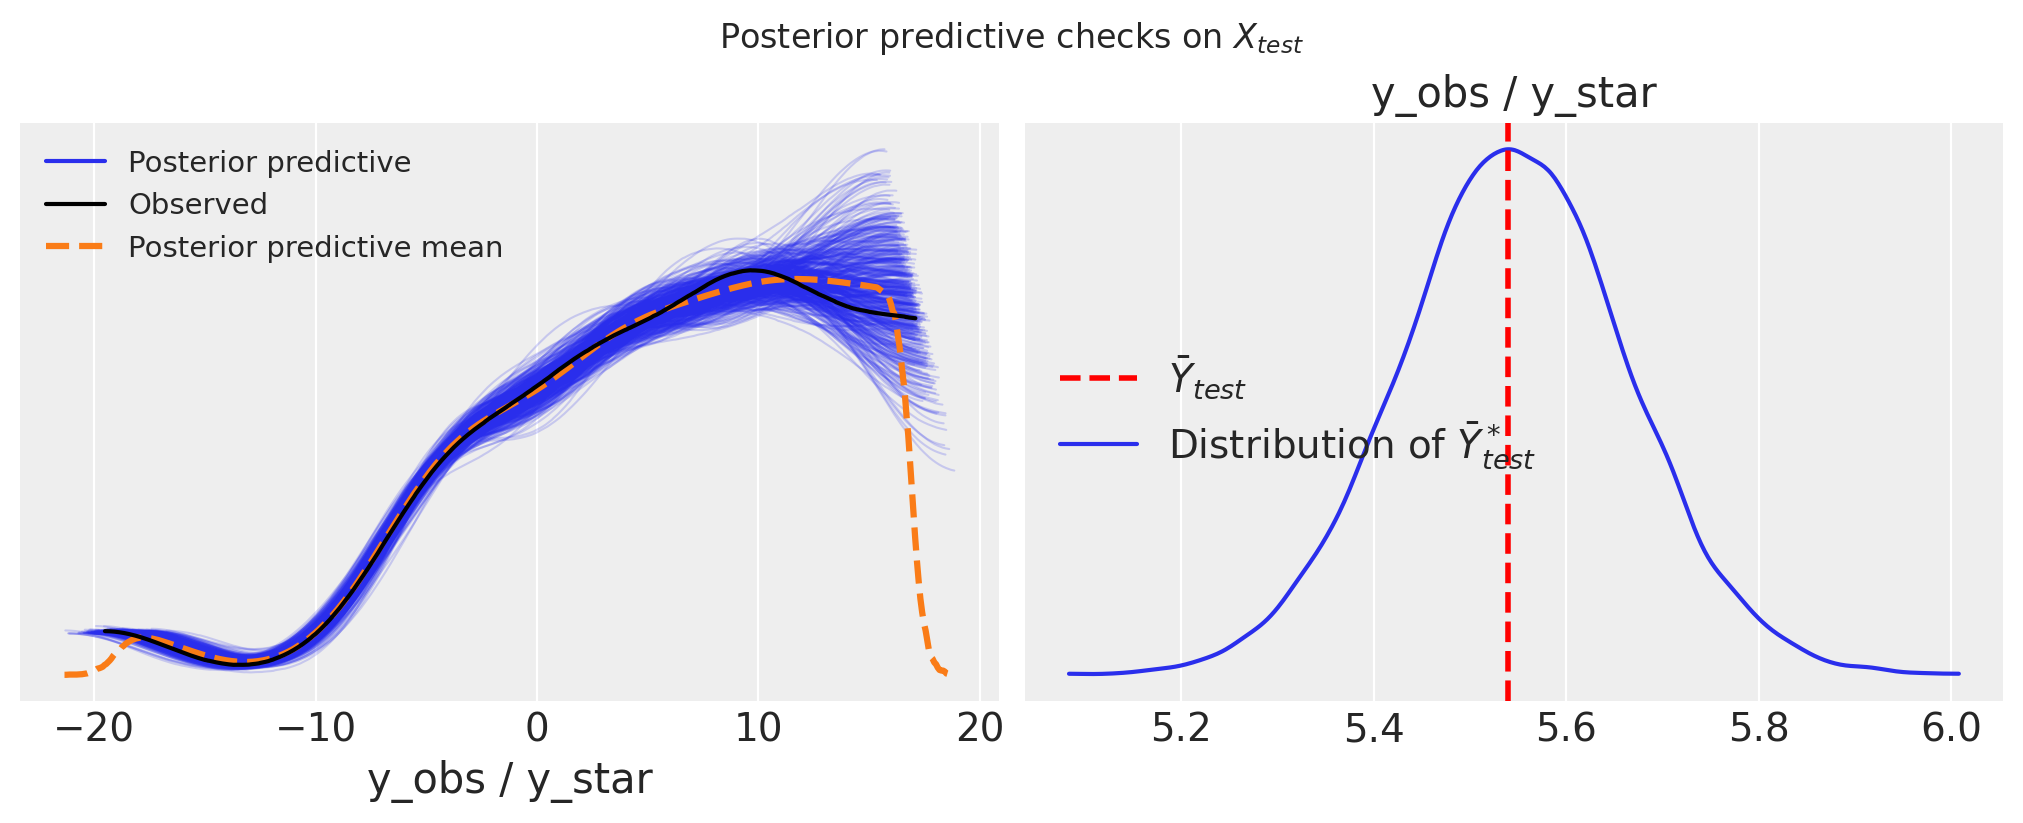

In [37]:
# -- Generate and plot posterior predictive samples from X_test

model_test = make_model(theta_space, g, eta, X_test, Y_test, theta_names,
                        theta_names_aux[:1], mle_theta_tr)

with model_test:
    print("Generating posterior predictive on hold-out data...")
    pp_test = utils.generate_pp(idata_pymc, X_test, theta_names, rng=rng)
    idata_pp_test = utils.pp_to_idata(
        [pp_test], idata_pymc, ['y_star'], y_obs=Y_test)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

utils.plot_ppc(idata_pp_test, n_samples=500,
               ax=axs[0], data_pairs={"y_obs": "y_star"})

az.plot_bpv(idata_pp_test, kind='t_stat', t_stat='mean',
            plot_mean=False, ax=axs[1],
            bpv=False, data_pairs={"y_obs": "y_star"})
axs[1].axvline(Y_test.mean(), ls="--",
               color="r", lw=2, label=r"$\bar Y_{test}$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y_{test}^*$")])
_ = axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = utils.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Next we look at the MSE when using several point-estimates for the parameters, as well as the mean of the posterior samples.

In [38]:
# -- Compute metrics using several point estimates

df_metrics_pymc = pd.DataFrame(columns=results_columns)

# Posterior mean estimate
Y_hat_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
metrics_pp = utils.regression_metrics(Y_test, Y_hat_pp)
df_metrics_pymc.loc[0] = [
    "pymc_posterior_mean",
    p_hat,
    metrics_pp["mse"],
    metrics_pp["rmse"],
    metrics_pp["r2"]
]

# Point estimates
for i, pe in enumerate(point_estimates):
    Y_hat_pe = utils.point_predict(
        X_test, idata_pymc,
        theta_names, pe)
    metrics_pe = utils.regression_metrics(Y_test, Y_hat_pe)
    df_metrics_pymc.loc[i + 1] = [
        "pymc_" + pe,
        p_hat,
        metrics_pe["mse"],
        metrics_pe["rmse"],
        metrics_pe["r2"]
    ]

df_metrics_pymc.sort_values(results_columns[-2], inplace=True)
df_metrics_pymc.style.hide_index()

In [39]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = pd.DataFrame(columns=results_columns)

for pe in point_estimates:
    df_var_sel = bayesian_var_sel(
        idata_pymc, theta_space, theta_names, X_fd,
        Y, X_test_fd, Y_test, folds, prefix="pymc",
        point_est=pe)

    df_metrics_pymc_var_sel = df_metrics_pymc_var_sel.append(df_var_sel)

df_metrics_pymc_var_sel.sort_values(
    results_columns[-2], inplace=True)
df_metrics_pymc_var_sel.style.hide_index()

### Save & Load

In [42]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-p-fixed.nc")

In [43]:
# -- Load

idata_pymc = az.from_netcdf("pymc-p-fixed.nc")

## Notebook metadata

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu May 05 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 7.30.1

emcee     : 3.1.1
autopep8  : 1.6.0
matplotlib: 3.5.1
arviz     : 0.11.4
sys       : 3.9.12 (main, Mar 28 2022, 11:54:36) 
[GCC 11.2.0]
scipy     : 1.7.3
pandas    : 1.3.5
skfda     : 0.0
json      : 2.0.9
numpy     : 1.20.3
logging   : 0.5.1.2

Watermark: 2.2.0

